# SOFTWARE EMPLEADO


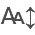

In [4]:
#
import os, sys
sys.path.append(os.path.abspath('notebooks/'))

#
import pandas as pd
import numpy as np

#
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

In [5]:
#
def sort_by_column(df, column, custom_order=None, secondary_column=None):
    if custom_order:
        df[column] = pd.Categorical(df[column], categories=custom_order, ordered=True)
    if secondary_column:
        return df.sort_values(by=[column, secondary_column])
    return df.sort_values(column)

## Mis funciones

### Análisis de la varianza


In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene, kruskal
import pingouin as pg
import scikit_posthocs as sp

# ---------------------
# Prueba 1: ANOVA + Tukey
# ---------------------
def run_anova_tukey(df, metric, group_col, alpha=0.05):
    model = ols(f'{metric} ~ C({group_col})', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    display(anova_table)

    p_value = anova_table.loc[f'C({group_col})', 'PR(>F)']
    if p_value < alpha:
        tukey = pairwise_tukeyhsd(df[metric], df[group_col], alpha=alpha)
        tukey_df = pd.DataFrame(
            data=tukey._results_table.data[1:],
            columns=tukey._results_table.data[0]
        )
        print("\n🔎 Comparaciones por pares (Tukey HSD):")
        display(tukey_df)

# ---------------------
# Prueba 2: Welch + Games–Howell
# ---------------------

def enrich_posthoc_table(df, alpha=0.05):
    """Añade columnas de interpretación a tabla de comparaciones post-hoc."""
    def interpret_significance(p):
        return "Significativa" if p < alpha else "No significativa"

    df = df.copy()
    df['Significance'] = df['pval'].apply(interpret_significance)
    return df

def run_welch_gameshowell(df, metric, group_col, alpha=0.05):
    welch = pg.welch_anova(dv=metric, between=group_col, data=df)
    display(welch)

    if welch['p-unc'][0] < alpha:
        gh = pg.pairwise_gameshowell(data=df, dv=metric, between=group_col)
        
        def interpret_significance(p):
            return "Significative" if p < alpha else "Non significative"
        
        gh['Significance'] = gh['pval'].apply(interpret_significance)
        
        print("\n📊 Welch ANOVA + Games-Howell")
        display(gh)

# ---------------------
# Prueba 3: Kruskal + Dunn
# ---------------------
def run_kruskal_dunn(df, metric, group_col, alpha=0.05):
    groups = [df[df[group_col] == g][metric] for g in df[group_col].unique()]
    kw_stat, kw_p = kruskal(*groups)
    display(pd.DataFrame({'H': [kw_stat], 'pval': [kw_p]}))

    if kw_p < alpha:
        dunn = sp.posthoc_dunn(df, val_col=metric, group_col=group_col, p_adjust='bonferroni')
        print("\n🔎 Comparaciones por pares (Dunn con Bonferroni):")
        display(dunn)

# =====================
# Función principal
# =====================
def run_group_comparison(df, metric, group_col='pred_method', alpha=0.05):
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS ESTADÍSTICO PARA: {metric.upper()}")
    print(f"{'='*60}")
    
    # 1. Verificar supuestos
    model = ols(f'{metric} ~ C({group_col})', data=df).fit()
    _, p_normality = shapiro(model.resid)
    norm_ok = p_normality >= alpha

    groups = [df[df[group_col] == g][metric] for g in df[group_col].unique()]
    _, p_homog = levene(*groups)
    homog_ok = p_homog >= alpha

    print(f"• Normalidad (Shapiro-Wilk): p = {p_normality:.4f} {'✅' if norm_ok else '❌'}")
    print(f"• Homocedasticidad (Levene): p = {p_homog:.4f} {'✅' if homog_ok else '❌'}")

    # 2. Selección de prueba
    if norm_ok and homog_ok:
        print("\n📊 ANOVA clásico + Tukey HSD")
        run_anova_tukey(df, metric, group_col, alpha)
    elif norm_ok and not homog_ok:
        print("\n📊 Welch ANOVA + Games-Howell")
        run_welch_gameshowell(df, metric, group_col, alpha)
    else:
        print("\n📊 Kruskal-Wallis + Dunn")
        run_kruskal_dunn(df, metric, group_col, alpha)

### Gráfica de dispersión de Cobertura - Tamaño Medio del Conjunto

In [7]:
from typing import Iterable, Tuple, Optional, Union
import matplotlib.pyplot as plt

def plot_coverage_vs_interval_width(
    mean_pred_interval_widths,
    empirical_coverages,
    model_types,
    colors,
    confidence_level=None,
    figsize=(8, 6),
    dpi=100
) -> None:

    # Convertir a listas
    mean_pred_interval_widths = list(mean_pred_interval_widths)
    empirical_coverages = list(empirical_coverages)
    model_types = list(model_types)
    colors = list(colors)

    if not (len(mean_pred_interval_widths) == len(empirical_coverages) == len(model_types) == len(colors)):
        raise ValueError("All input iterables must have the same length.")

    # Multiplicar cobertura por 100 para mostrar en %
    empirical_coverages_percent = [c * 100 for c in empirical_coverages]
    confidence_level_percent = confidence_level * 100 if confidence_level is not None else None

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    plt.grid(True, zorder=0)

    # Scatter plot
    plt.scatter(
        mean_pred_interval_widths,
        empirical_coverages_percent,
        c=colors,
        marker='o',
        s=100,
        edgecolor='white',
        linewidth=0.5,
        zorder=3
    )

    # Línea de referencia
    if confidence_level_percent is not None:
        plt.axhline(y=confidence_level_percent, color='black', linestyle='--', linewidth=1.0, zorder=2)

    # Etiquetas y título
    plt.xlabel("Amplitud Media de Intervalo de Predicción", fontsize=12)
    plt.ylabel("Cobertura empírica (%)", fontsize=12)

    # Legend
    seen = set()
    legend_elements = []
    for model, color in zip(model_types, colors):
        if model not in seen:
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', color='w', label=model,
                           markerfacecolor=color, markersize=10, markeredgecolor='white')
            )
            seen.add(model)
    plt.legend(handles=legend_elements, title="Método")

    # Ticks del eje Y cada 1%
    ymin, ymax = plt.gca().get_ylim()
    plt.yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------

def plot_coverage_vs_set_size(
    mean_set_sizes: Iterable[float], 
    empirical_coverages: Iterable[float], 
    model_types: Iterable[str],
    colors: Iterable[str],
    confidence_level: float = None,
    figsize: Tuple[float, float] = (8, 6),
    dpi: int = 100 
) -> None:

    # Convertimos a listas para poder indexar y hacer validaciones
    mean_pred_set_sizes = list(mean_set_sizes)
    empirical_coverages = list(empirical_coverages)
    model_types = list(model_types)
    colors = list(colors)

    if not (len(mean_pred_set_sizes) == len(empirical_coverages) == len(model_types) == len(colors)):
        raise ValueError("All input iterables must have the same length.")
    
    # Multiplicar cobertura por 100 para mostrar en %
    empirical_coverages_percent = [c * 100 for c in empirical_coverages]
    confidence_level_percent = confidence_level * 100 if confidence_level is not None else None
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.grid(True, zorder=0)

    # Graficar todos los puntos como círculos
    plt.scatter(
        mean_pred_set_sizes,
        empirical_coverages_percent,
        c=colors,
        marker='o',
        s=100,
        edgecolor='white',
        linewidth=0.5,
        zorder=3
    )
    
    # Línea de referencia
    if confidence_level_percent is not None:
        plt.axhline(y=confidence_level_percent, color='black', linestyle='--', linewidth=1.0, zorder=2)

    # Etiquetas y título
    plt.xlabel("Tamaño Medio de Conjunto de Predicción", fontsize=12)
    plt.ylabel("Cobertura empírica (%)", fontsize=12)

    # Legend
    seen = set()
    legend_elements = []
    for model, color in zip(model_types, colors):
        if model not in seen:
            legend_elements.append(
                plt.Line2D([0], [0], marker='o', color='w', label=model,
                           markerfacecolor=color, markersize=10, markeredgecolor='white')
            )
            seen.add(model)
    
    # Obtener los límites actuales del eje Y
    ymin, ymax = plt.gca().get_ylim()

    # Ajustar los ticks cada 1 dentro del rango visible
    plt.yticks(np.arange(np.floor(ymin), np.ceil(ymax) + 1, 1))

    plt.legend(handles=legend_elements, title="Método")
    plt.tight_layout()
    plt.show()

### Histograma de anchos de intervalo con tasa de cobertura

In [8]:
import seaborn as sns

def plot_interval_width_histogram(
    df: pd.DataFrame,
    pred_method: str,
    confidence: float,
    bins: int = 30,
    figsize: Tuple[float, float] = (8, 5),
    dpi: int = 150
) -> plt.Figure:
    
    # Filtrar datos
    filtered_data = df.query(
        "pred_method == @pred_method and confidence == @confidence"
    ).copy()

    # Etiquetas de cobertura
    filtered_data['coverage_status'] = filtered_data['is_covered'].map({
        True: 'Cubre valor real',
        False: 'No cubre valor real'
    })

    # Crear figura
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    sns.histplot(
        data=filtered_data,
        x='pred_interval_width',
        hue='coverage_status',
        bins=bins,
        multiple='stack',
        palette=['#4CAF50', '#F44336'],  # verde y rojo
        edgecolor='white',
        linewidth=0.5,
        ax=ax,
        kde=True,
        legend=True
    )

    # Cobertura empírica
    coverage_rate = filtered_data['is_covered'].mean()

    # Personalización
    ax.set_title(
        f"Modelo: {pred_method} | "+ 
        f"Nivel de confianza: {confidence*100:.1f} % | " + 
        f"Cobertura empírica: {coverage_rate:.1%}",
        fontsize=13,
        pad=10
    )
    ax.set_xlabel("Amplitud del intervalo de predicción", fontsize=13)
    ax.set_ylabel("Frecuencia", fontsize=13)
    ax.tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    return fig

### C

In [9]:
import matplotlib.ticker as mticker

import matplotlib.ticker as mticker

def plot_coverage_by_interval(
    df: pd.DataFrame, 
    bin_width: float = 0.5,
    vmin=0.9, 
    vmax=1.0, 
    center=0.95, 
    figsize=(9,7), 
    dpi=150, 
    bins=None
) -> plt.Figure:
    
    sns.set(style="white")
    
    # Copia temporal y agrupar en franjas de bin_width
    df_temp = df.assign(
        interval_bin=lambda x: np.floor(x['pred_interval_width'] / bin_width) * bin_width
    )

    # Cobertura media y conteo
    coverage_matrix = df_temp.pivot_table(
        index='interval_bin',
        columns='pred_method',
        values='is_covered',
        aggfunc='mean'
    ).sort_index()

    count_matrix = df_temp.pivot_table(
        index='interval_bin',
        columns='pred_method',
        values='is_covered',
        aggfunc='count'
    ).sort_index()

    # Anotaciones
    annotations = coverage_matrix.mul(100).round(2).astype(str) + "\n(n=" + count_matrix.astype(str) + ")"

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.heatmap(
        coverage_matrix,
        annot=annotations,
        fmt="",
        cmap="RdBu",
        center=center,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Cobertura empírica (%)'},
        linecolor='#ededed',   # color de las líneas
        linewidths=0.5       # grosor de las líneas
    )

    # Colorbar con ticks cada 1%
    cbar = ax.collections[0].colorbar
    ticks = np.arange(vmin, vmax + 0.001, 0.01)
    cbar.set_ticks(ticks)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))
    
    # Etiquetas de intervalos en el eje Y
    y_labels = [f"[{bin_val:.1f}, {bin_val + bin_width:.1f})" for bin_val in coverage_matrix.index]
    ax.set_yticklabels(y_labels, rotation=0)

    # Labels y título
    ax.set_xlabel("Método")
    ax.set_ylabel("Amplitud del intervalo")
    plt.tight_layout()
    return plt.gcf()

#-------------------------------------------------------------------------------------------

def plot_coverage_by_set_size(
    df: pd.DataFrame,
    vmin=0.9,
    vmax=1.0,
    center=0.95,
    figsize=(9,7),
    dpi=110
) -> plt.Figure:

    sns.set(style="white")

    # Cobertura media y conteo
    coverage_matrix = df.pivot_table(
        index='pred_set_size',
        columns='pred_method',
        values='is_covered',
        aggfunc='mean'
    ).sort_index()

    count_matrix = df.pivot_table(
        index='pred_set_size',
        columns='pred_method',
        values='is_covered',
        aggfunc='count'
    ).sort_index()

    # Anotaciones
    annotations = coverage_matrix.mul(100).round(2).astype(str) + "\n(n=" + count_matrix.astype(str) + ")"

    # Crear figura
    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.heatmap(
        coverage_matrix,
        annot=annotations,
        fmt="",
        cmap="RdBu",
        center=center,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Cobertura empírica (%)'},
        linecolor='#ededed',   # color de las líneas
        linewidths=0.5
    )

    # Colorbar con ticks cada 1%
    cbar = ax.collections[0].colorbar
    ticks = np.arange(vmin, vmax + 0.001, 0.01)
    cbar.set_ticks(ticks)
    cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

    # Labels eje Y (tamaños de conjunto)
    ax.set_yticklabels([str(int(s)) for s in coverage_matrix.index], rotation=0)

    # Labels y título
    ax.set_xlabel("Método")
    ax.set_ylabel("Tamaño del conjunto")
    plt.tight_layout()
    return plt.gcf()

### D

In [10]:
def plot_interval_predictions(
    pred_point_values,
    pred_lower_bound,
    pred_upper_bound,
    true_values,
    figsize: Tuple[float, float] = (10, 6),
    dpi=150
) -> None:
    
    # Ordena por los valores predichos
    order = np.argsort(true_values)
    y_true = true_values[order]
    y_pred = pred_point_values[order]
    y_lower = pred_lower_bound[order]
    y_upper = pred_upper_bound[order]
    
    x = np.arange(len(y_true))
    
    # Grafica
    plt.figure(figsize=figsize, dpi=dpi)
    plt.plot(x, y_true, label='Valor verdadero', 
             color='black', linewidth=2, marker='s', markersize=4)
    plt.plot(x, y_pred, label='Predicción puntual', 
             color='steelblue', linestyle='--', marker='o', markersize=4)
    plt.fill_between(x, y_lower, y_upper, 
                     color='lightcoral', alpha=0.5, label='Intervalo de confianza')
    
    # Identificar valores fuera del intervalo
    outside_mask = (y_true < y_lower) | (y_true > y_upper)
    
    # Graficar los puntos fuera del intervalo en rojo
    plt.scatter(x[outside_mask], y_true[outside_mask], 
                color='red', marker='x', s=50, label='Fuera del intervalo')
    
    plt.xlabel('Instancia (ordenada por valor verdadero)')
    plt.ylabel('Valor')
    plt.title('Predicción con intervalos de confianza')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# PROBLEMA 1: ESTIMACIÓN DE EDAD

## 1.1. Carga de los resultados y obtención de métricas

In [11]:
# Carga de datos
df_AE_by_instance = pd.read_csv('results/I_AE_maxillofacial_test_results.csv')

# Nueva columna: error absoluto
df_AE_by_instance['absolute_error'] = (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_point_value']).abs()

# Nueva columna: error cuadrático
df_AE_by_instance['squared_error'] = (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_point_value']).pow(2)

# Nueva columna: tamaño del intervalo medio
df_AE_by_instance['pred_interval_width'] = df_AE_by_instance['pred_upper_bound'] - df_AE_by_instance['pred_lower_bound']

# Nueva columna: cobertura (true/false)
df_AE_by_instance['is_covered'] = (df_AE_by_instance['true_value'] >= df_AE_by_instance['pred_lower_bound']) & \
                          (df_AE_by_instance['true_value'] <= df_AE_by_instance['pred_upper_bound'])

# Nueva columna: interval score  
alpha = 1 - df_AE_by_instance['confidence']
df_AE_by_instance['interval_score'] = (
    (df_AE_by_instance['pred_upper_bound'] - df_AE_by_instance['pred_lower_bound']) 
    + (2 / alpha) * (df_AE_by_instance['pred_lower_bound'] - df_AE_by_instance['true_value']).clip(lower=0) 
    + (2 / alpha) * (df_AE_by_instance['true_value'] - df_AE_by_instance['pred_upper_bound']).clip(lower=0)
)

# Ordena por iteración y por tipo de predicción
custom_order = ['base', 'ICP', 'QR', 'CQR']
df_AE_by_instance = sort_by_column(df_AE_by_instance, 'pred_method', custom_order, 
                                   secondary_column='iteration')

display(df_AE_by_instance)

pred_method  confidence  iteration  pred_point_value  pred_lower_bound  \
62408        base        0.95          1         25.515577         22.621857   
62409        base        0.95          1         20.000740         17.107019   
62410        base        0.95          1         15.073482         12.179760   
62411        base        0.95          1         20.802036         17.908316   
62412        base        0.95          1         22.948490         20.054770   
...           ...         ...        ...               ...               ...   
86075         CQR        0.95         10         20.012934         16.992012   
86076         CQR        0.95         10         15.257071         12.857668   
86077         CQR        0.95         10         21.307367         18.184923   
86078         CQR        0.95         10         17.229155         14.617528   
86079         CQR        0.95         10         22.022461         18.888872   

       pred_upper_bound  true_value sex  absolute_error  squared_error  \
62408         28.409298   25.304110   F        0.211467       0.044718   
62409         22.894461   21.670000   M        1.669260       2.786429   
62410         17.967203   14.890411   F        0.183071       0.033515   
62411         23.695757   17.367123   F        3.434913      11.798627   
62412         25.842211   23.180822   M        0.232332       0.053978   
...                 ...         ...  ..             ...            ...   
86075         23.303413   21.868494   F        1.855560       3.443103   
86076         18.043465   14.000000   F        1.257071       1.580227   
86077         24.601334   23.400000   M        2.092633       4.379113   
86078         20.246599   17.080000   F        0.149155       0.022247   
86079         25.507736   22.493151   F        0.470690       0.221549   

       pred_interval_width  is_covered  interval_score  
62408             5.787441        True        5.787441  
62409             5.787442        True        5.787442  
62410             5.787443        True        5.787443  
62411             5.787441       False       27.435161  
62412             5.787441        True        5.787441  
...                    ...         ...             ...  
86075             6.311401        True        6.311401  
86076             5.185797        True        5.185797  
86077             6.416411        True        6.416411  
86078             5.629071        True        5.629071  
86079             6.618864        True        6.618864  

[86080 rows x 13 columns]

In [12]:
# Agrupar y calcular métricas por ejecución
df_AE_by_run = (
    df_AE_by_instance
    .groupby(['pred_method', 'confidence', 'iteration'])
    .agg(
        mean_absolute_error=('absolute_error', 'mean'),
        mean_squared_error=('squared_error', 'mean'),
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean'),
        mean_interval_score=('interval_score', 'mean')
    )
    .reset_index()
)

# Ordena por iteración y por tipo de predicción
df_AE_by_run = sort_by_column(df_AE_by_run, 'pred_method', custom_order, secondary_column='iteration')

display(df_AE_by_run)

/tmp/ipykernel_18107/722887977.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'iteration'])


pred_method  confidence  iteration  mean_absolute_error  \
0         base        0.95          1             1.171062   
1         base        0.95          2             1.164163   
2         base        0.95          3             1.159705   
3         base        0.95          4             1.154154   
4         base        0.95          5             1.152093   
5         base        0.95          6             1.169693   
6         base        0.95          7             1.164040   
7         base        0.95          8             1.152880   
8         base        0.95          9             1.156370   
9         base        0.95         10             1.156382   
10         ICP        0.95          1             1.216907   
11         ICP        0.95          2             1.191153   
12         ICP        0.95          3             1.195872   
13         ICP        0.95          4             1.190384   
14         ICP        0.95          5             1.186140   
15         ICP        0.95          6             1.204845   
16         ICP        0.95          7             1.182120   
17         ICP        0.95          8             1.192624   
18         ICP        0.95          9             1.202605   
19         ICP        0.95         10             1.179335   
20          QR        0.95          1             1.175862   
21          QR        0.95          2             1.152299   
22          QR        0.95          3             1.163305   
23          QR        0.95          4             1.166417   
24          QR        0.95          5             1.176630   
25          QR        0.95          6             1.178654   
26          QR        0.95          7             1.174188   
27          QR        0.95          8             1.160785   
28          QR        0.95          9             1.161031   
29          QR        0.95         10             1.156491   
30         CQR        0.95          1             1.193692   
31         CQR        0.95          2             1.177988   
32         CQR        0.95          3             1.214452   
33         CQR        0.95          4             1.197176   
34         CQR        0.95          5             1.183910   
35         CQR        0.95          6             1.160087   
36         CQR        0.95          7             1.184727   
37         CQR        0.95          8             1.187578   
38         CQR        0.95          9             1.190593   
39         CQR        0.95         10             1.174374   

    mean_squared_error  empirical_coverage  mean_interval_width  \
0             2.410060            0.937732             5.787442   
1             2.351821            0.940985             5.809360   
2             2.336333            0.943773             5.874771   
3             2.329387            0.945167             5.843990   
4             2.339705            0.947955             5.946445   
5             2.397107            0.942844             5.918022   
6             2.375048            0.946561             5.938238   
7             2.329395            0.945167             5.884632   
8             2.350438            0.944238             5.886276   
9             2.380793            0.940985             5.937267   
10            2.525547            0.955390             6.404678   
11            2.448463            0.953996             6.285198   
12            2.500021            0.955855             6.298767   
13            2.485209            0.945632             6.200245   
14            2.436068            0.953532             6.271740   
15            2.495357            0.950279             6.153557   
16            2.457094            0.946561             6.243980   
17            2.468473            0.944703             6.184113   
18            2.496139            0.954926             6.423626   
19            2.420561            0.956784             6.332336   
20            2.409981            0.881041           

## 1.2. Análisis de las métricas para la estimación puntual de edad

### Tabla resumen por método y ejecución

In [13]:
# Pivot, reorganiza métricas y añade medias
pivot_point_metrics = (
    df_AE_by_run
    .pivot(
        index='iteration',
        columns=['pred_method', 'confidence'],
        values=['mean_absolute_error', 'mean_squared_error']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_point_metrics.loc['Media'] = pivot_point_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_point_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de la varianza

In [14]:
for metric in ['mean_absolute_error', 'mean_squared_error']:
    run_group_comparison(df_AE_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: MEAN_ABSOLUTE_ERROR
• Normalidad (Shapiro-Wilk): p = 0.5049 ✅
• Homocedasticidad (Levene): p = 0.5292 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df          F        PR(>F)
C(pred_method)  0.007811   3.0  22.066863  2.780057e-08
Residual        0.004248  36.0        NaN           NaN


🔎 Comparaciones por pares (Tukey HSD):


group1 group2  meandiff   p-adj   lower   upper  reject
0    CQR    ICP    0.0077  0.3950 -0.0053  0.0208   False
1    CQR     QR   -0.0199  0.0013 -0.0330 -0.0068    True
2    CQR   base   -0.0264  0.0000 -0.0395 -0.0133    True
3    ICP     QR   -0.0276  0.0000 -0.0407 -0.0145    True
4    ICP   base   -0.0341  0.0000 -0.0472 -0.0211    True
5     QR   base   -0.0065  0.5440 -0.0196  0.0066   False


ANÁLISIS ESTADÍSTICO PARA: MEAN_SQUARED_ERROR
• Normalidad (Shapiro-Wilk): p = 0.4742 ✅
• Homocedasticidad (Levene): p = 0.0256 ❌

📊 Welch ANOVA + Games-Howell


Source  ddof1      ddof2         F         p-unc       np2
0  pred_method      3  19.469882  24.36733  8.416643e-07  0.584511


📊 Welch ANOVA + Games-Howell


A    B   mean(A)   mean(B)      diff        se         T         df  \
0  base  ICP  2.360009  2.473293 -0.113284  0.013828 -8.192202  17.731376   
1  base   QR  2.360009  2.391071 -0.031062  0.017741 -1.750826  14.774457   
2  base  CQR  2.360009  2.464846 -0.104837  0.019838 -5.284670  13.540248   
3   ICP   QR  2.473293  2.391071  0.082222  0.018393  4.470398  15.882205   
4   ICP  CQR  2.473293  2.464846  0.008447  0.020423  0.413632  14.571215   
5    QR  CQR  2.391071  2.464846 -0.073775  0.023251 -3.172978  17.625611   

       pval    hedges       Significance  
0  0.000001 -3.508861      Significative  
1  0.334087 -0.749909  Non significative  
2  0.000656 -2.263515      Significative  
3  0.002001  1.914749      Significative  
4  0.975261  0.177166  Non significative  
5  0.025133 -1.359041      Significative

## 1.3. Análisis de las métricas para la estimación interválica de edad

### Tabla resumen por método y ejecución

In [15]:
# Pivot, ordenar métricas y añadir medias
pivot_intervalic_metrics = (
    df_AE_by_run
    .pivot(
        index='iteration',
        columns=['pred_method', 'confidence'],
        values=['empirical_coverage', 'mean_interval_width', 'mean_interval_score']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
    .reindex(columns=['empirical_coverage', 'mean_interval_width', 'mean_interval_score'], level=0)
)

# Añadimos fila de medias
pivot_intervalic_metrics.loc['Media'] = pivot_intervalic_metrics.mean()

# Multiplicar columnas de cobertura por 100 (selección por nivel)
pivot_intervalic_metrics.loc[:, pd.IndexSlice['empirical_coverage', :, :]] *= 100

# Mostrar tabla con formato
styled_table = pivot_intervalic_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de la varianza

In [16]:
# Ejemplo de uso:
for metric in ['empirical_coverage', 'mean_interval_width']:
    run_group_comparison(df_AE_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: EMPIRICAL_COVERAGE
• Normalidad (Shapiro-Wilk): p = 0.1020 ✅
• Homocedasticidad (Levene): p = 0.0773 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df           F        PR(>F)
C(pred_method)  0.027066   3.0  298.355457  1.789224e-25
Residual        0.001089  36.0         NaN           NaN


🔎 Comparaciones por pares (Tukey HSD):


group1 group2  meandiff   p-adj   lower   upper  reject
0    CQR    ICP    0.0041  0.3577 -0.0025  0.0107   False
1    CQR     QR   -0.0597  0.0000 -0.0663 -0.0531    True
2    CQR   base   -0.0041  0.3479 -0.0108  0.0025   False
3    ICP     QR   -0.0638  0.0000 -0.0704 -0.0572    True
4    ICP   base   -0.0082  0.0100 -0.0148 -0.0016    True
5     QR   base    0.0556  0.0000  0.0490  0.0622    True


ANÁLISIS ESTADÍSTICO PARA: MEAN_INTERVAL_WIDTH
• Normalidad (Shapiro-Wilk): p = 0.4366 ✅
• Homocedasticidad (Levene): p = 0.0103 ❌

📊 Welch ANOVA + Games-Howell


Source  ddof1     ddof2            F         p-unc       np2
0  pred_method      3  18.26843  1829.130498  8.028571e-23  0.981726


📊 Welch ANOVA + Games-Howell


A    B   mean(A)   mean(B)      diff        se          T         df  \
0  base  ICP  5.882644  6.279824 -0.397180  0.033267 -11.939067  14.971706   
1  base   QR  5.882644  4.642667  1.239977  0.020556  60.323103  15.066508   
2  base  CQR  5.882644  5.998719 -0.116075  0.048382  -2.399132  11.632650   
3   ICP   QR  6.279824  4.642667  1.637157  0.030336  53.967669  11.592518   
4   ICP  CQR  6.279824  5.998719  0.281105  0.053278   5.276201  15.138510   
5    QR  CQR  4.642667  5.998719 -1.356052  0.046415 -29.215730  10.039959   

           pval     hedges       Significance  
0  2.616830e-08  -5.113708      Significative  
1  0.000000e+00  25.837425      Significative  
2  1.317597e-01  -1.027590  Non significative  
3  1.310063e-14  23.115283      Significative  
4  4.702840e-04   2.259888      Significative  
5  2.448659e-10 -12.513601      Significative

### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

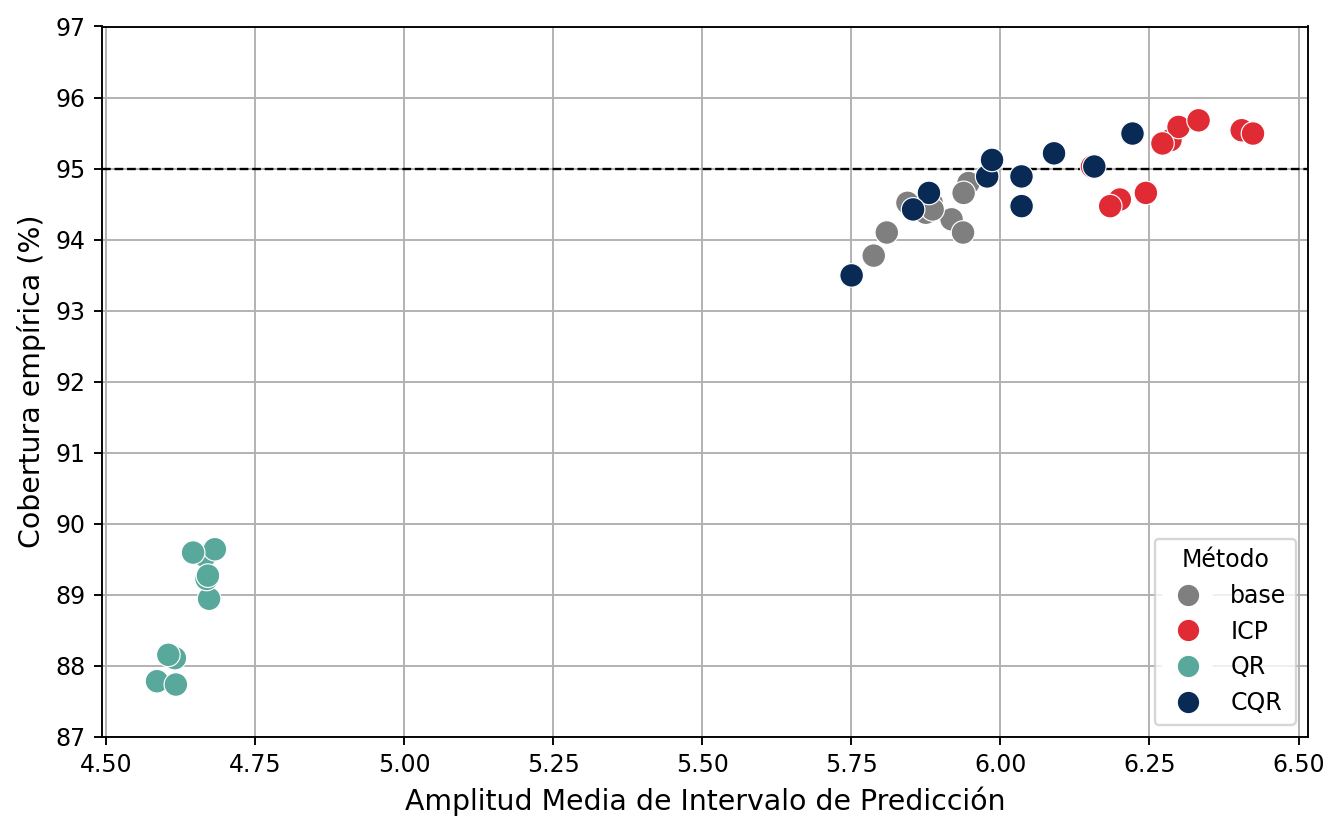

In [17]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}
df_AE_by_run_to_plot = df_AE_by_run.copy()
df_AE_by_run_to_plot['color'] = df_AE_by_run_to_plot['pred_method'].map(color_dict)

#
plot_coverage_vs_interval_width(
    mean_pred_interval_widths = df_AE_by_run_to_plot['mean_interval_width'],
    empirical_coverages = df_AE_by_run_to_plot['empirical_coverage'],
    model_types = df_AE_by_run_to_plot['pred_method'],
    colors = df_AE_by_run_to_plot['color'],
    confidence_level = 0.95,
    figsize=(8,5),
    dpi=170
)

## 1.4. Análisis de la cobertura en base al tamaño del intervalo

### Histograma del ancho del intervalo con distinción de cobertura

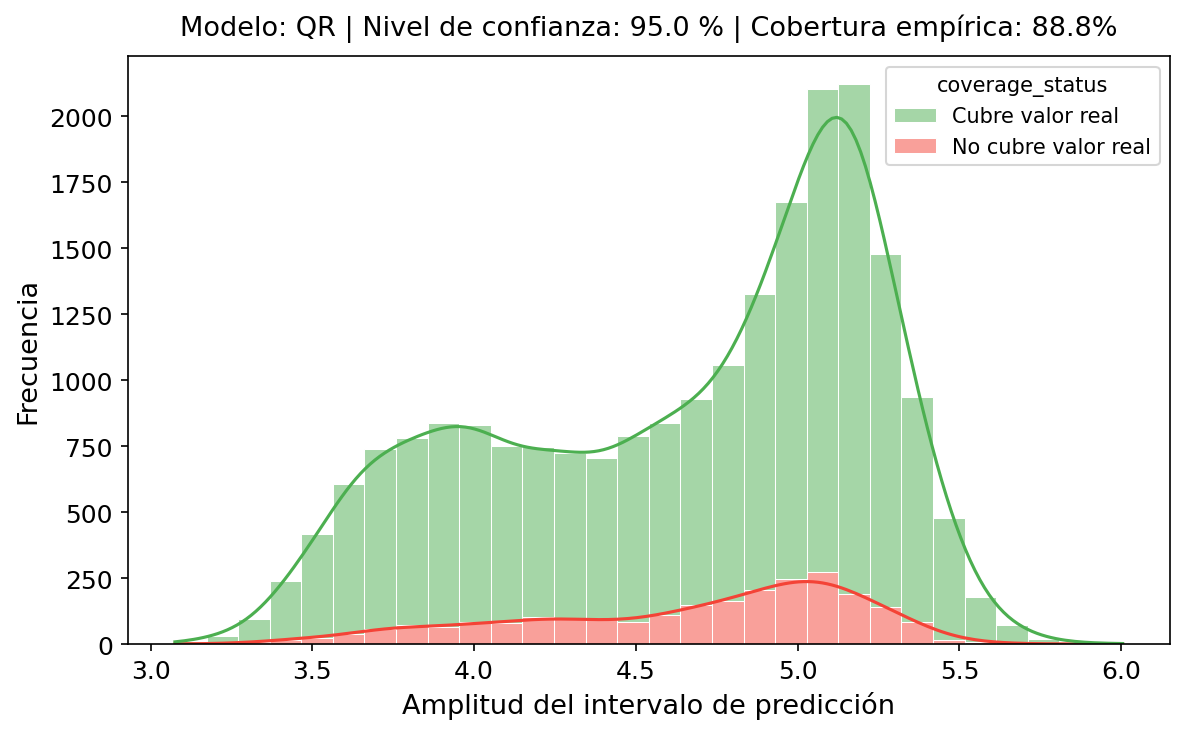

In [18]:
fig = plot_interval_width_histogram(df_AE_by_instance, pred_method='QR', confidence=0.95)
plt.show()

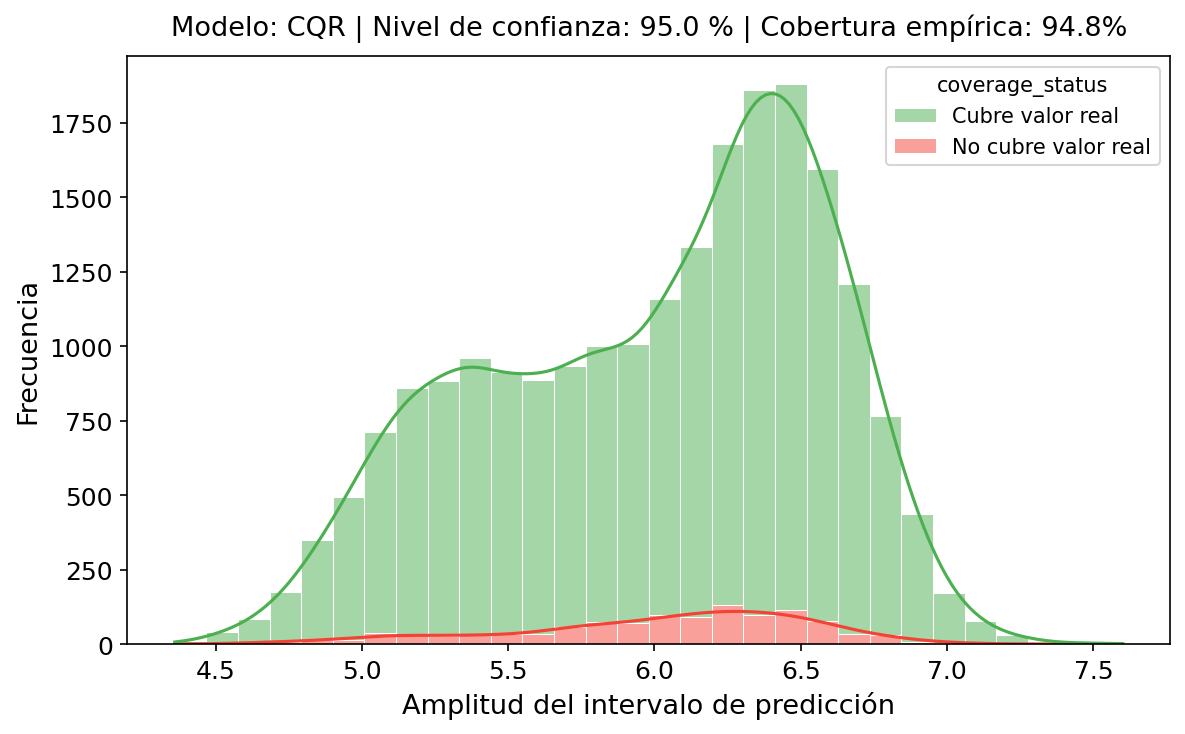

In [19]:
fig = plot_interval_width_histogram(df_AE_by_instance, pred_method='CQR', confidence=0.95)
plt.show()

### Tabla resumen de la cobertura por tamaño de intervalo para cada método

/tmp/ipykernel_18107/1252586063.py:24: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  coverage_matrix = df_temp.pivot_table(
/tmp/ipykernel_18107/1252586063.py:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_matrix = df_temp.pivot_table(


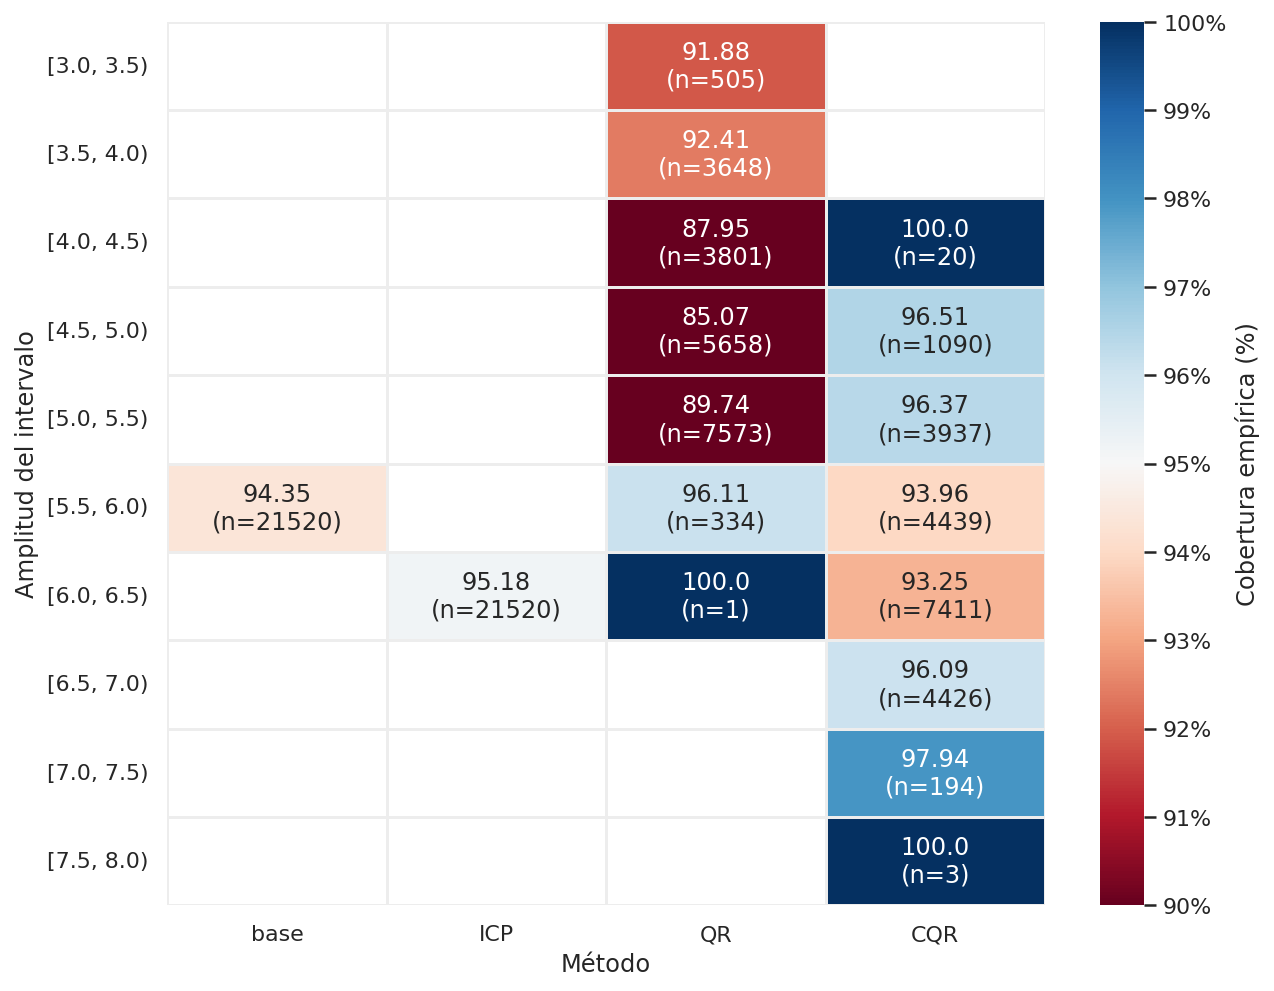

In [20]:
fig = plot_coverage_by_interval(df_AE_by_instance, bin_width=0.5, dpi=145)
plt.show()

## 1.5. Análisis de la cobertura en base a la edad cronológica

### Tabla resumen de cobertura y amplitud media del intervalo por edad cronológica

In [21]:
# Agrupamos por método, confianza y edad truncada, calculando cobertura y ancho medio
df_AE_by_true_age = (
    df_AE_by_instance.assign(true_value_int=df_AE_by_instance['true_value'].astype(int))
    .groupby(['pred_method', 'confidence', 'true_value_int'])
    .agg(
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean')
    )
    .reset_index()
    .pivot(
        index='true_value_int',
        columns=['pred_method', 'confidence'],
        values=['empirical_coverage', 'mean_interval_width']
    )
)

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in df_AE_by_true_age.columns if 'empirical_coverage' in str(col)]
df_AE_by_true_age[coverage_cols] = df_AE_by_true_age[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = df_AE_by_true_age.style.format("{:.2f}")
show(styled_table, allow_html=True)

/tmp/ipykernel_18107/4085143488.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'true_value_int'])


### Gráfica de ...

In [22]:
# Agrupar por método, confianza y edad entera, calculando métricas
df_AE_coverage_by_age = (
    df_AE_by_instance.assign(true_value_int=df_AE_by_instance['true_value'].astype(int))
    .groupby(['pred_method', 'confidence', 'true_value_int'])
    .agg(
        mean_coverage=('is_covered', lambda x: round(x.mean() * 100, 2)),
        mean_interval_width=('pred_interval_width', lambda x: round(x.mean(), 2)),
        mean_interval_score=('interval_score', lambda x: round(x.mean(), 2)),
        count=('is_covered', 'count')
    )
    .reset_index()
)

/tmp/ipykernel_18107/2650802836.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'true_value_int'])


/tmp/ipykernel_18107/1632033325.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


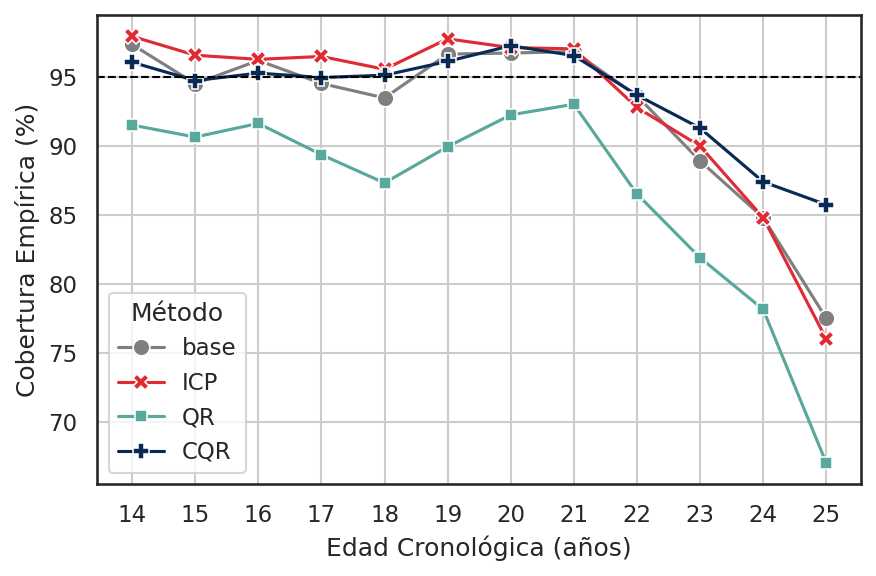

In [23]:
# Configuración de la figura
plt.figure(figsize=(6, 4), dpi=150)
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

# Lineplot
lineplot = sns.lineplot(
    data=df_AE_coverage_by_age,
    x='true_value_int',
    y='mean_coverage',
    hue='pred_method',
    style='pred_method',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None
)

# Ajuste del tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)

# Etiquetas y estilo
plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Cobertura Empírica (%)')
plt.legend(title='Método')
plt.grid(True)

# Ticks del eje X por cada año
plt.xticks(range(df_AE_coverage_by_age['true_value_int'].min(),
                 df_AE_coverage_by_age['true_value_int'].max() + 1, 1))

# Línea de referencia para cobertura objetivo
plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_18107/959508369.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


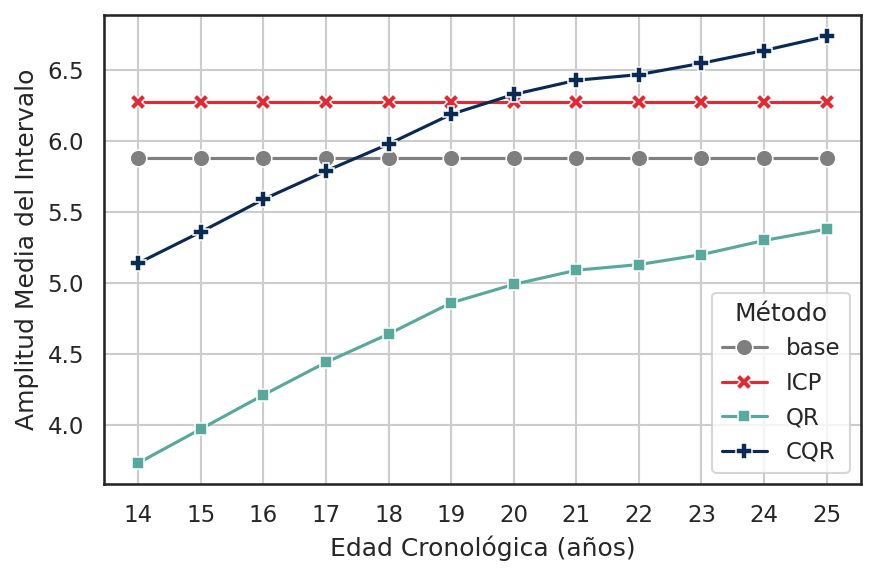

In [24]:
# Configuración de la figura
plt.figure(figsize=(6, 4), dpi=150)
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

# Lineplot
lineplot = sns.lineplot(
    data=df_AE_coverage_by_age,
    x='true_value_int',
    y='mean_interval_width',
    hue='pred_method',
    style='pred_method',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None
)

# Ajuste del tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)

# Etiquetas y estilo
plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Amplitud Media del Intervalo')
plt.legend(title='Método')
plt.grid(True)

# Ticks del eje X por cada año
plt.xticks(range(df_AE_coverage_by_age['true_value_int'].min(),
                 df_AE_coverage_by_age['true_value_int'].max() + 1, 1))


plt.tight_layout()
plt.show()

## 1.6. Análisis de la cobertura en base a la edad cronológica y el sexo

In [25]:
# Agrupar y calcular métricas por ejecución
df_AE_by_run_with_sex = (
    df_AE_by_instance
    .groupby(['pred_method', 'confidence', 'iteration', 'sex'])
    .agg(
        mean_absolute_error=('absolute_error', 'mean'),
        mean_squared_error=('squared_error', 'mean'),
        empirical_coverage=('is_covered', 'mean'),
        mean_interval_width=('pred_interval_width', 'mean'),
        mean_interval_score=('interval_score', 'mean')
    )
    .reset_index()
)

# Ordena por iteración y por tipo de predicción
df_AE_by_run_with_sex = sort_by_column(df_AE_by_run_with_sex, 'pred_method', custom_order, secondary_column='iteration')

display(df_AE_by_run_with_sex)

/tmp/ipykernel_18107/3052394720.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'iteration', 'sex'])


pred_method  confidence  iteration sex  mean_absolute_error  \
0         base        0.95          1   F             1.191982   
1         base        0.95          1   M             1.146044   
2         base        0.95          2   F             1.177052   
3         base        0.95          2   M             1.148750   
4         base        0.95          3   F             1.181219   
..         ...         ...        ...  ..                  ...   
75         CQR        0.95          8   M             1.141989   
76         CQR        0.95          9   F             1.216788   
77         CQR        0.95          9   M             1.159267   
78         CQR        0.95         10   F             1.205267   
79         CQR        0.95         10   M             1.137427   

    mean_squared_error  empirical_coverage  mean_interval_width  \
0             2.572164            0.935154             5.787442   
1             2.216196            0.940816             5.787442   
2             2.478190            0.937713             5.809360   
3             2.200695            0.944898             5.809360   
4             2.497761            0.938567             5.874771   
..                 ...                 ...                  ...   
75            2.183553            0.951020             5.856341   
76            2.614466            0.947952             6.094802   
77            2.179853            0.957143             6.083971   
78            2.628102            0.946246             5.982113   
79            2.173858            0.957143             5.990482   

    mean_interval_score  
0              8.677038  
1              7.490710  
2              8.501483  
3              7.380681  
4              8.446544  
..                  ...  
75             7.250279  
76             8.403174  
77             7.149222  
78             8.596352  
79             7.220203  

[80 rows x 9 columns]

In [26]:
# Pivot, reorganiza métricas y añade medias
pivot_point_metrics = (
    df_AE_by_run_with_sex
    .pivot(
        index='iteration',
        columns=['sex', 'pred_method', 'confidence'],
        values=['mean_absolute_error', 'mean_squared_error']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_point_metrics.loc['Media'] = pivot_point_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_point_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

In [27]:
# Agrupar por método, confianza, sexo y edad entera
df_AE_coverage_by_age_sex = (
    df_AE_by_instance.assign(true_value_int=df_AE_by_instance['true_value'].astype(int))
    .groupby(['sex', 'pred_method', 'confidence', 'true_value_int'])
    .agg(
        mean_coverage=('is_covered', lambda x: round(x.mean() * 100, 2)),
        mean_interval_width=('pred_interval_width', lambda x: round(x.mean(), 2)),
        mean_interval_score=('interval_score', lambda x: round(x.mean(), 2)),
        count=('is_covered', 'count')
    )
    .reset_index()
)


df_AE_coverage_by_age_sex 

/tmp/ipykernel_18107/2517596808.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sex', 'pred_method', 'confidence', 'true_value_int'])


sex pred_method  confidence  true_value_int  mean_coverage  \
0    F        base        0.95              14          96.22   
1    F        base        0.95              15          94.77   
2    F        base        0.95              16          95.39   
3    F        base        0.95              17          94.14   
4    F        base        0.95              18          95.53   
..  ..         ...         ...             ...            ...   
91   M         CQR        0.95              21          95.73   
92   M         CQR        0.95              22          97.43   
93   M         CQR        0.95              23          93.01   
94   M         CQR        0.95              24          85.93   
95   M         CQR        0.95              25          91.18   

    mean_interval_width  mean_interval_score  count  
0                  5.88                 7.10   1110  
1                  5.88                 8.54   1070  
2                  5.88                 8.12   1280  
3                  5.88                 7.52   1110  
4                  5.88                 7.19   1140  
..                  ...                  ...    ...  
91                 6.45                 7.76    960  
92                 6.51                 6.98    740  
93                 6.57                 9.41    830  
94                 6.66                11.67    270  
95                 6.75                 8.08    170  

[96 rows x 8 columns]

In [28]:
df_AE_coverage_by_age_sex

sex pred_method  confidence  true_value_int  mean_coverage  \
0    F        base        0.95              14          96.22   
1    F        base        0.95              15          94.77   
2    F        base        0.95              16          95.39   
3    F        base        0.95              17          94.14   
4    F        base        0.95              18          95.53   
..  ..         ...         ...             ...            ...   
91   M         CQR        0.95              21          95.73   
92   M         CQR        0.95              22          97.43   
93   M         CQR        0.95              23          93.01   
94   M         CQR        0.95              24          85.93   
95   M         CQR        0.95              25          91.18   

    mean_interval_width  mean_interval_score  count  
0                  5.88                 7.10   1110  
1                  5.88                 8.54   1070  
2                  5.88                 8.12   1280  
3                  5.88                 7.52   1110  
4                  5.88                 7.19   1140  
..                  ...                  ...    ...  
91                 6.45                 7.76    960  
92                 6.51                 6.98    740  
93                 6.57                 9.41    830  
94                 6.66                11.67    270  
95                 6.75                 8.08    170  

[96 rows x 8 columns]

In [29]:
# Pivot, reorganiza métricas y añade medias
pivot_interval_metrics = (
    df_AE_coverage_by_age_sex
    .pivot(
        index='true_value_int',
        columns=['sex', 'pred_method', 'confidence'],
        values=['mean_coverage', 'mean_interval_width']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_interval_metrics.loc['Media'] = pivot_interval_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_interval_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

/tmp/ipykernel_18107/4031124041.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


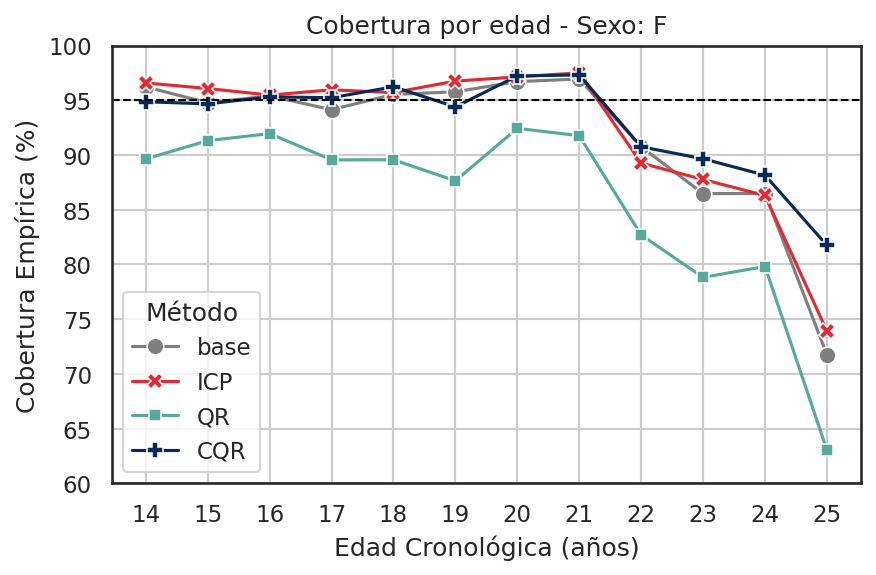

/tmp/ipykernel_18107/4031124041.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


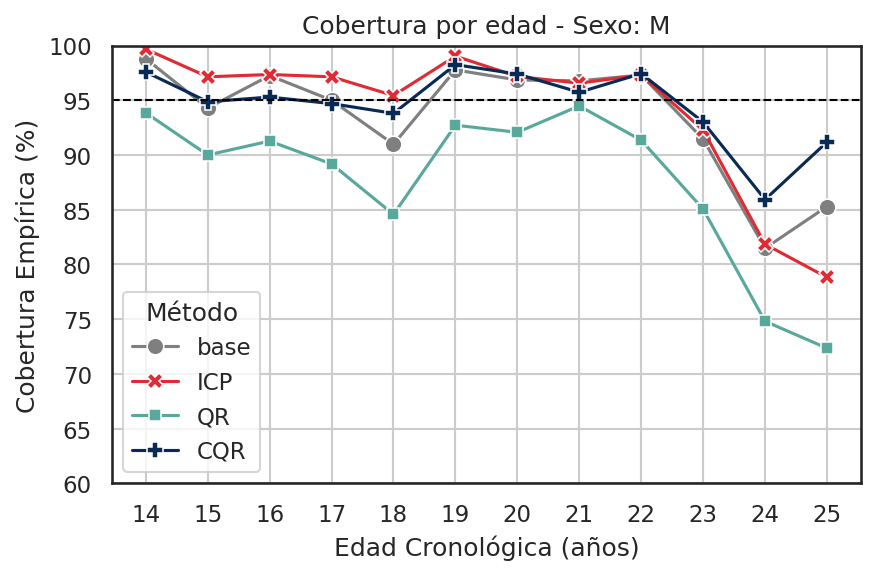

In [30]:

# Colores por método
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

# Crear un gráfico por sexo
sexes = df_AE_coverage_by_age_sex['sex'].unique()

for s in sexes:
    plt.figure(figsize=(6, 4), dpi=150)
    
    subset = df_AE_coverage_by_age_sex[df_AE_coverage_by_age_sex['sex'] == s]
    
    lineplot = sns.lineplot(
        data=subset,
        x='true_value_int',
        y='mean_coverage',
        hue='pred_method',
        style='pred_method',
        markers=True,
        dashes=False,
        palette=color_dict,
        ci=None
    )

    # Ajuste del tamaño de los marcadores
    plt.setp(lineplot.lines, markersize=8)

    # Etiquetas y estilo
    plt.xlabel('Edad Cronológica (años)')
    plt.ylabel('Cobertura Empírica (%)')
    plt.title(f'Cobertura por edad - Sexo: {s}')
    plt.legend(title='Método')
    plt.grid(True)

    # Ticks del eje X por cada año
    plt.xticks(range(subset['true_value_int'].min(),
                     subset['true_value_int'].max() + 1, 1))

    # Línea de referencia para cobertura objetivo (ej. 95%)
    plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)
    
    # Establecer rango del eje Y entre 60 y 100
    plt.ylim(60, 100)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_18107/3985394902.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


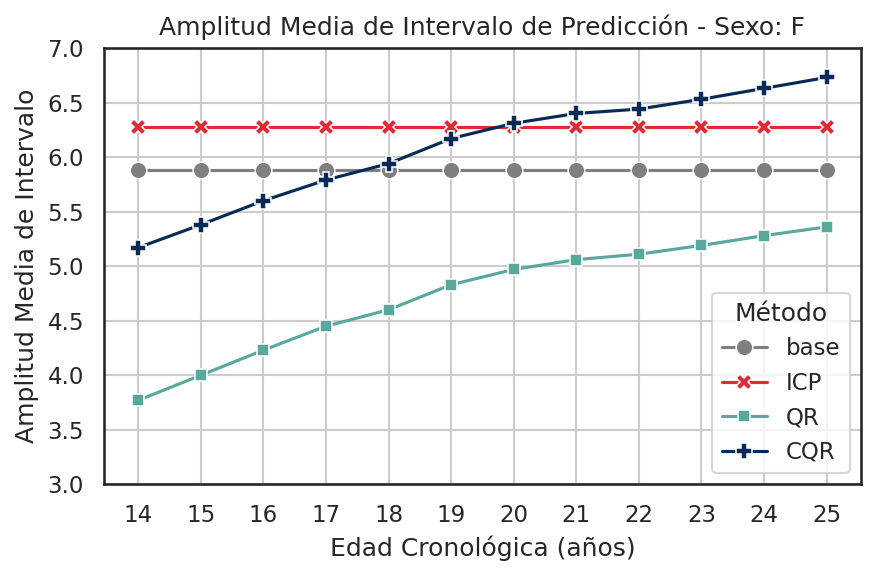

/tmp/ipykernel_18107/3985394902.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


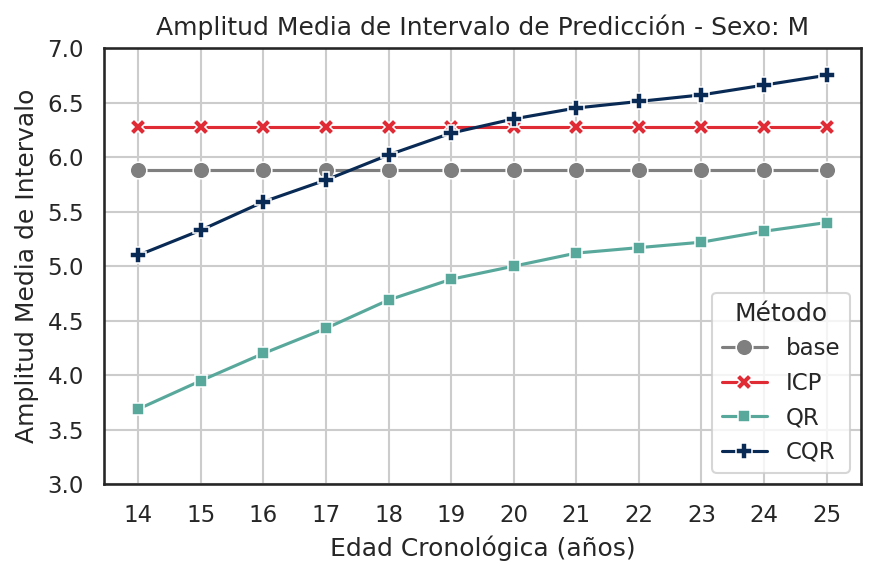

In [31]:

# Colores por método
color_dict = {'base': '#7f7f7f', 'ICP': '#e02b35', 'QR': '#59a89c', 'CQR': '#082a54'}

# Crear un gráfico por sexo
sexes = df_AE_coverage_by_age_sex['sex'].unique()

for s in sexes:
    plt.figure(figsize=(6, 4), dpi=150)
    
    subset = df_AE_coverage_by_age_sex[df_AE_coverage_by_age_sex['sex'] == s]
    
    lineplot = sns.lineplot(
        data=subset,
        x='true_value_int',
        y='mean_interval_width',
        hue='pred_method',
        style='pred_method',
        markers=True,
        dashes=False,
        palette=color_dict,
        ci=None
    )

    # Ajuste del tamaño de los marcadores
    plt.setp(lineplot.lines, markersize=8)

    # Etiquetas y estilo
    plt.xlabel('Edad Cronológica (años)')
    plt.ylabel('Amplitud Media de Intervalo')
    plt.title(f'Amplitud Media de Intervalo de Predicción - Sexo: {s}')
    plt.legend(title='Método')
    plt.grid(True)

    # Ticks del eje X por cada año
    plt.xticks(range(subset['true_value_int'].min(),
                     subset['true_value_int'].max() + 1, 1))

    # Línea de referencia para cobertura objetivo (ej. 95%)
    plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)
    
    # Establecer rango del eje Y entre 60 y 100
    plt.ylim(3, 7)

    plt.tight_layout()
    plt.show()

## 1.7. Otras pruebas

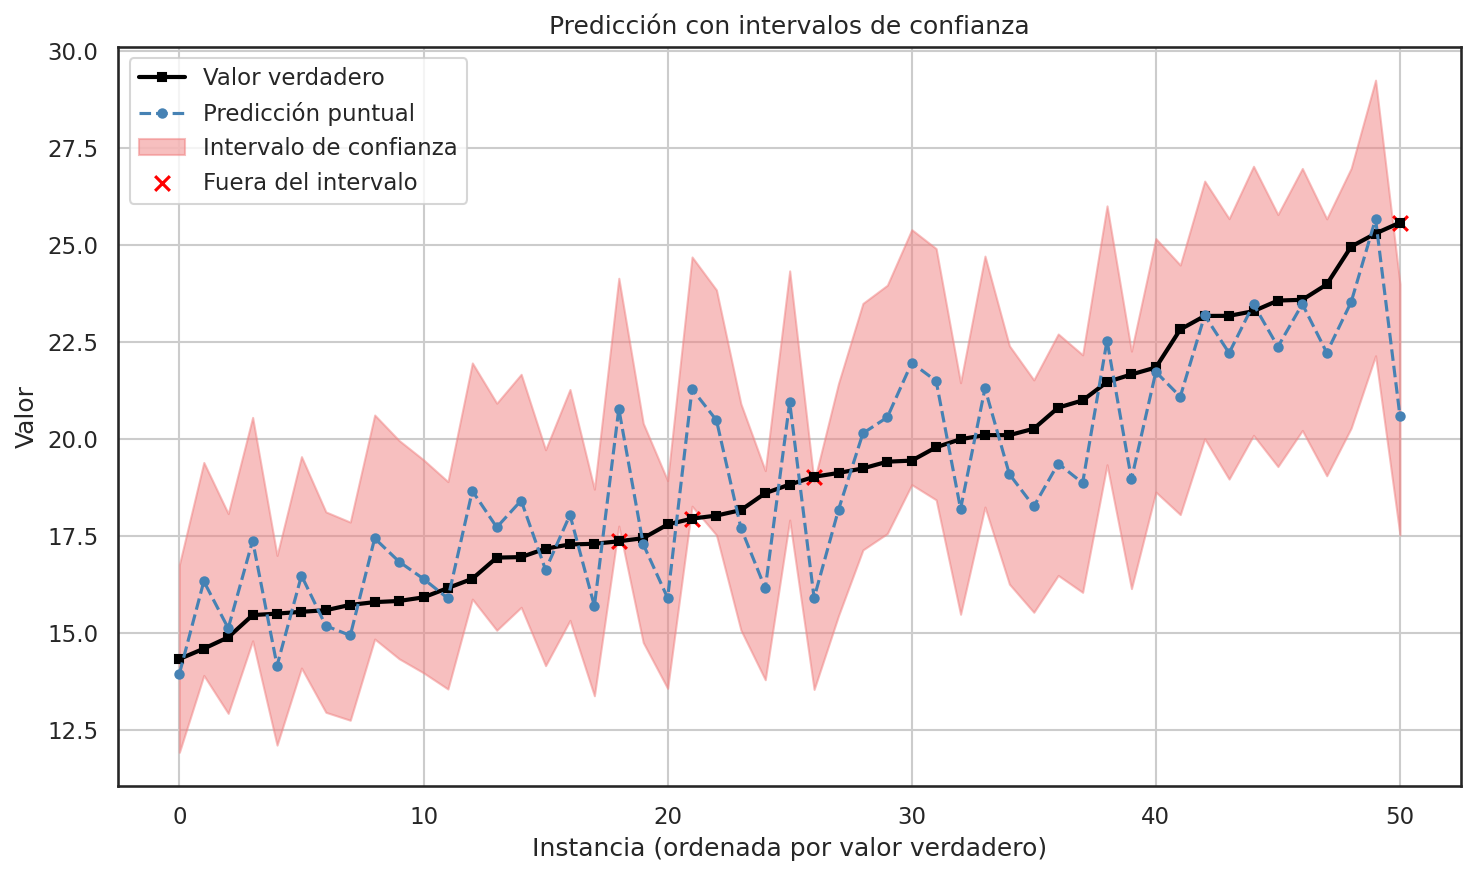

In [32]:
df_AE_by_instance_misclassified_CQR = (df_AE_by_instance[(df_AE_by_instance['pred_method'] == 'CQR')])

n = 51

# Extraer los valores y convertir a tensores
pred_point_values = df_AE_by_instance_misclassified_CQR['pred_point_value'].values[0:n]
pred_lower_bound = df_AE_by_instance_misclassified_CQR['pred_lower_bound'].values[0:n]
pred_upper_bound = df_AE_by_instance_misclassified_CQR['pred_upper_bound'].values[0:n]
true_values = df_AE_by_instance_misclassified_CQR['true_value'].values[0:n]

# Llamar a la función de plot
plot_interval_predictions(
    pred_point_values=pred_point_values,
    pred_lower_bound=pred_lower_bound,
    pred_upper_bound=pred_upper_bound,
    true_values=true_values
)

# PROBLEMA 2: CLASIFICACIÓN DE MAYORÍA DE EDAD

## 2.1. Carga de resultados y obtención de métricas

In [30]:
# Carga de datos
df_MC_by_instance = pd.read_csv('results/II_MC_maxillofacial_test_results.csv')

# Nueva columna: verdaderos positivos
df_MC_by_instance['TP'] = (df_MC_by_instance['pred_class'] == 1) & (df_MC_by_instance['true_class'] == 1)

# Nueva columna: verdaderos negativos
df_MC_by_instance['TN'] = (df_MC_by_instance['pred_class'] == 0) & (df_MC_by_instance['true_class'] == 0)

# falsos positivos
df_MC_by_instance['FP'] = (df_MC_by_instance['pred_class'] == 1) & (df_MC_by_instance['true_class'] == 0)

# Nueva columna: falsos negativos
df_MC_by_instance['FN'] = (df_MC_by_instance['pred_class'] == 0) & (df_MC_by_instance['true_class'] == 1)

# Nueva columna: cobertura (true/false)
df_MC_by_instance['is_covered'] = ((df_MC_by_instance['true_class'] == 0) & (df_MC_by_instance['pred_set_under_18'] == 1)) | \
                          ((df_MC_by_instance['true_class'] == 1) & (df_MC_by_instance['pred_set_over_18'] == 1))
                          
# Nueva columna: tamaño del conjunto de predicción
df_MC_by_instance['pred_set_size'] = df_MC_by_instance['pred_set_under_18'] + df_MC_by_instance['pred_set_over_18']

# Nueva columna: set score
alpha = 1 - df_MC_by_instance['confidence']
df_MC_by_instance['set_score'] = df_MC_by_instance['pred_set_size'] + 1/alpha * (~df_MC_by_instance['is_covered'])

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_MC_by_instance = sort_by_column(df_MC_by_instance, 'pred_method', custom_order, 
                                      secondary_column='iteration')

display(df_MC_by_instance)

pred_method  confidence  iteration  pred_class  pred_set_under_18  \
0            base        0.95          1           1                  0   
1            base        0.95          1           1                  0   
2            base        0.95          1           0                  1   
3            base        0.95          1           1                  0   
4            base        0.95          1           1                  0   
...           ...         ...        ...         ...                ...   
64555         MCM        0.95         10           1                  1   
64556         MCM        0.95         10           0                  1   
64557         MCM        0.95         10           1                  0   
64558         MCM        0.95         10           0                  1   
64559         MCM        0.95         10           1                  0   

       pred_set_over_18  true_class sex     TP     TN     FP     FN  \
0                     1           1   F   True  False  False  False   
1                     1           1   M   True  False  False  False   
2                     0           0   F  False   True  False  False   
3                     1           0   F  False  False   True  False   
4                     1           1   M   True  False  False  False   
...                 ...         ...  ..    ...    ...    ...    ...   
64555                 1           1   F   True  False  False  False   
64556                 0           0   F  False   True  False  False   
64557                 1           1   M   True  False  False  False   
64558                 0           0   F  False   True  False  False   
64559                 1           1   F   True  False  False  False   

       is_covered  pred_set_size  set_score  
0            True              1        1.0  
1            True              1        1.0  
2            True              1        1.0  
3           False              1       21.0  
4            True              1        1.0  
...           ...            ...        ...  
64555        True              2        2.0  
64556        True              1        1.0  
64557        True              1        1.0  
64558        True              1        1.0  
64559        True              1        1.0  

[64560 rows x 15 columns]

In [31]:
# Agrupar y calcular métricas
df_MC_by_run = (
    df_MC_by_instance
    .groupby(['pred_method', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': (g['TP'].sum() + g['TN'].sum()) / len(g),
        'sensitivity': g['TP'].sum() / (g['TP'].sum() + g['FN'].sum()),
        'specifity': g['TN'].sum() / (g['TN'].sum() + g['FP'].sum()),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM']
df_MC_by_run = sort_by_column(df_MC_by_run, 'pred_method', custom_order, secondary_column='iteration')

display(df_MC_by_run)

/tmp/ipykernel_25759/3155980822.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'iteration'])
/tmp/ipykernel_25759/3155980822.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


pred_method  confidence  iteration  accuracy  sensitivity  specifity  \
0         base        0.95          1  0.879182     0.907621   0.835873   
1         base        0.95          2  0.881506     0.916089   0.828839   
2         base        0.95          3  0.876859     0.889145   0.858148   
3         base        0.95          4  0.874535     0.903002   0.831184   
4         base        0.95          5  0.871747     0.899923   0.828839   
5         base        0.95          6  0.877323     0.893764   0.852286   
6         base        0.95          7  0.876859     0.903002   0.837046   
7         base        0.95          8  0.881041     0.919169   0.822978   
8         base        0.95          9  0.881041     0.913010   0.832356   
9         base        0.95         10  0.879182     0.903002   0.842907   
10         LAC        0.95          1  0.867100     0.882987   0.842907   
11         LAC        0.95          2  0.870818     0.899153   0.827667   
12         LAC        0.95          3  0.871283     0.889145   0.844080   
13         LAC        0.95          4  0.873606     0.911470   0.815944   
14         LAC        0.95          5  0.871283     0.901463   0.825322   
15         LAC        0.95          6  0.875000     0.903002   0.832356   
16         LAC        0.95          7  0.870818     0.907621   0.814771   
17         LAC        0.95          8  0.868494     0.906082   0.811254   
18         LAC        0.95          9  0.872677     0.909931   0.815944   
19         LAC        0.95         10  0.869888     0.897614   0.827667   
20         MCM        0.95          1  0.867100     0.882987   0.842907   
21         MCM        0.95          2  0.870818     0.899153   0.827667   
22         MCM        0.95          3  0.871283     0.889145   0.844080   
23         MCM        0.95          4  0.873606     0.911470   0.815944   
24         MCM        0.95          5  0.871283     0.901463   0.825322   
25         MCM        0.95          6  0.875000     0.903002   0.832356   
26         MCM        0.95          7  0.870818     0.907621   0.814771   
27         MCM        0.95          8  0.868494     0.906082   0.811254   
28         MCM        0.95          9  0.872677     0.909931   0.815944   
29         MCM        0.95         10  0.869888     0.897614   0.827667   

    empirical_coverage  mean_set_size  mean_set_score  
0             0.879182       1.000000        3.416357  
1             0.881506       1.000000        3.369888  
2             0.876859       1.000000        3.462825  
3             0.874535       1.000000        3.509294  
4             0.871747       1.000000        3.565056  
5             0.877323       1.000000        3.453532  
6             0.876859       1.000000        3.462825  
7             0.881041       1.000000        3.379182  
8             0.881041       1.000000        3.379182  
9             0.879182       1.000000        3.416357  
10            0.948420       1.208178        2.239777  
11            0.947026       1.192379        2.251859  
12            0.946097       1.202602        2.280669  
13            0.947026       1.205855        2.265335  
14            0.945632       1.182621        2.269981  
15            0.947491       1.210037        2.260223  
16            0.945632       1.197491        2.284851  
17            0.948420       1.196561        2.228160  
18            0.945167       1.197026        2.293680  
19            0.951673       1.214219        2.180762  
20            0.948885       1.233736        2.256041  
21            0.935409       1.175651        2.467472  
22            0.949349       1.227230        2.240242  
23            0.940985       1.199349        2.379647  
24            0.946097       1.202138        2.280204  
25            0.951673       1.238848        2.205390  
26            0.941450       1.202138        2.373141  
27            0.945167       1.212825        2.309480  
28            0.946097       1.212361        2.290428

## 2.2. Análisis de las métricas para la clasificación puntual de mayoría de edad

### Tabla resumen por método y ejecución

In [32]:
# Pivot, reorganiza métricas y añade medias
pivot_point_metrics = (
    df_MC_by_run
    .pivot(
        index='iteration',
        columns=['pred_method', 'confidence'],
        values=['accuracy', 'sensitivity', 'specifity'] 
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_point_metrics.loc['Media'] = pivot_point_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_point_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de la varianza

In [33]:
# Ejemplo de uso:
for metric in ['accuracy', 'sensitivity', 'specifity']:
    run_group_comparison(df_MC_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: ACCURACY
• Normalidad (Shapiro-Wilk): p = 0.3876 ✅
• Homocedasticidad (Levene): p = 0.4541 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df          F    PR(>F)
C(pred_method)  0.000311   2.0  22.748976  0.000002
Residual        0.000185  27.0        NaN       NaN


🔎 Comparaciones por pares (Tukey HSD):


group1 group2  meandiff  p-adj   lower   upper  reject
0    LAC    MCM    0.0000    1.0 -0.0029  0.0029   False
1    LAC   base    0.0068    0.0  0.0039  0.0097    True
2    MCM   base    0.0068    0.0  0.0039  0.0097    True


ANÁLISIS ESTADÍSTICO PARA: SENSITIVITY
• Normalidad (Shapiro-Wilk): p = 0.1226 ✅
• Homocedasticidad (Levene): p = 0.9950 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df         F    PR(>F)
C(pred_method)  0.000103   2.0  0.604368  0.553645
Residual        0.002295  27.0       NaN       NaN


ANÁLISIS ESTADÍSTICO PARA: SPECIFITY
• Normalidad (Shapiro-Wilk): p = 0.0179 ❌
• Homocedasticidad (Levene): p = 0.9393 ✅

📊 Kruskal-Wallis + Dunn


H      pval
0  5.685612  0.058262

## 2.3. Análisis de las métricas para la clasificación conformal de mayoría de edad 


### Tabla resumen por método y ejecución

In [34]:
# Pivot, reorganiza métricas y añade medias
pivot_interval_metrics = (
    df_MC_by_run
    .pivot(
        index='iteration',
        columns=['pred_method', 'confidence'],
        values=['empirical_coverage', 'mean_set_size', 'mean_set_score']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_interval_metrics.loc['Media'] = pivot_interval_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_interval_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de la varianza

In [35]:
# Ejemplo de uso:
for metric in ['empirical_coverage', 'mean_set_size']:
    run_group_comparison(df_MC_by_run, metric)


ANÁLISIS ESTADÍSTICO PARA: EMPIRICAL_COVERAGE
• Normalidad (Shapiro-Wilk): p = 0.5463 ✅
• Homocedasticidad (Levene): p = 0.0791 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df            F        PR(>F)
C(pred_method)  0.030947   2.0  1277.781865  1.822727e-27
Residual        0.000327  27.0          NaN           NaN


🔎 Comparaciones por pares (Tukey HSD):


group1 group2  meandiff   p-adj   lower   upper  reject
0    LAC    MCM   -0.0025  0.2703 -0.0063  0.0014   False
1    LAC   base   -0.0693  0.0000 -0.0732 -0.0655    True
2    MCM   base   -0.0669  0.0000 -0.0707 -0.0630    True


ANÁLISIS ESTADÍSTICO PARA: MEAN_SET_SIZE
• Normalidad (Shapiro-Wilk): p = 0.0349 ❌
• Homocedasticidad (Levene): p = 0.0002 ❌

📊 Kruskal-Wallis + Dunn


H      pval
0  20.622222  0.000033


🔎 Comparaciones por pares (Dunn con Bonferroni):


base       LAC       MCM
base  1.000000  0.001295  0.000066
LAC   0.001295  1.000000  1.000000
MCM   0.000066  1.000000  1.000000

### Gráfica de dispersión Cobertura empírica - Amplitud media del intervalo

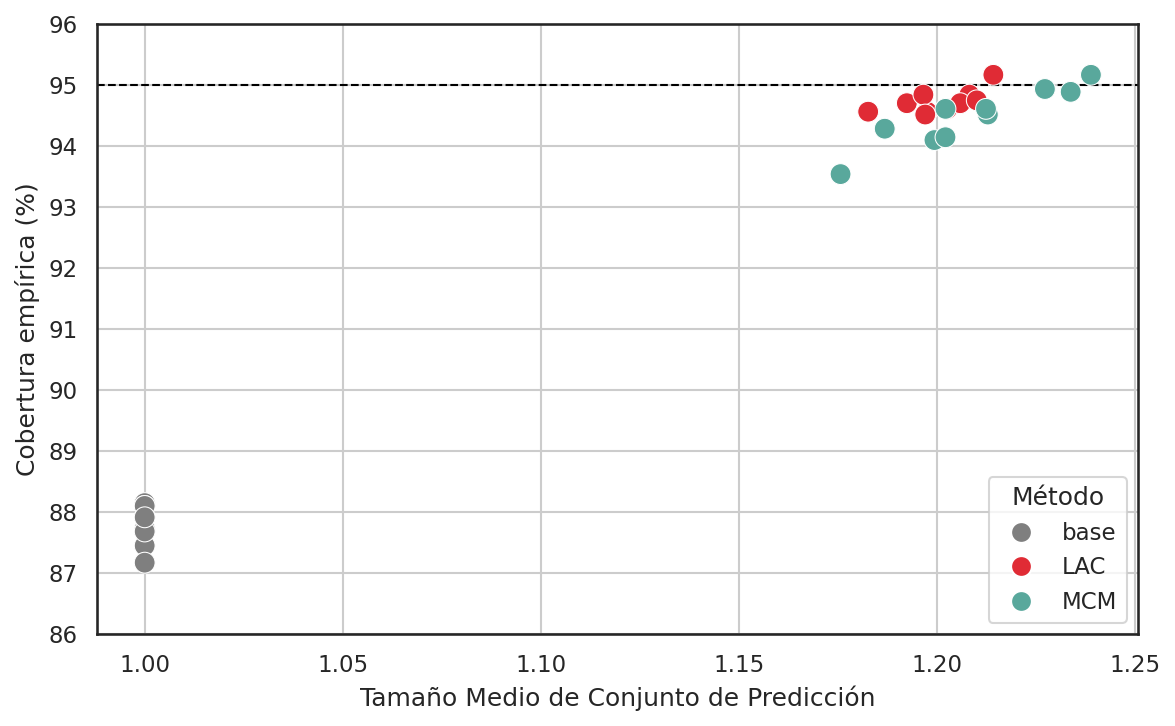

In [36]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c'}
df_MC_by_run_to_plot = df_MC_by_run.copy()
df_MC_by_run_to_plot['color'] = df_MC_by_run_to_plot['pred_method'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_MC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_MC_by_run_to_plot['empirical_coverage'],
    model_types=df_MC_by_run_to_plot['pred_method'],
    colors=df_MC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 2.4. Análisis de la cobertura en base a la clase

### Matriz de confusión conformal

In [37]:
def pred_set_label(row):
    if row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 0:
        return '{<18}'
    elif row['pred_set_under_18'] == 0 and row['pred_set_over_18'] == 1:
        return '{>=18}'
    elif row['pred_set_under_18'] == 1 and row['pred_set_over_18'] == 1:
        return '{<18,>=18}'
    else:
        return '∅'  # Por si acaso, aunque dices que nunca ocurre

df_MC_by_instance['pred_set_label'] = df_MC_by_instance.apply(pred_set_label, axis=1)

confusion_conformal = (
    df_MC_by_instance
    .groupby(['pred_method', 'confidence', 'true_class', 'pred_set_label'])
    .size()
    .reset_index(name='count')
)

empirical_coverage_by_group = (
    df_MC_by_instance
    .groupby(['pred_method', 'confidence'])['is_covered']
    .mean()
    .reset_index(name='empirical_coverage')
)

coverage_dict = {
    (row['pred_method'], row['confidence']): row['empirical_coverage']
    for _, row in empirical_coverage_by_group.iterrows()
}

# Posibles etiquetas de columnas en orden
pred_set_labels = ['{<18}', '{>=18}', '{<18,>=18}']

/tmp/ipykernel_25759/1846620123.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'true_class', 'pred_set_label'])
/tmp/ipykernel_25759/1846620123.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence'])['is_covered']


/tmp/ipykernel_25759/382371384.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (model, conf), group in confusion_conformal.groupby(['pred_method', 'confidence']):


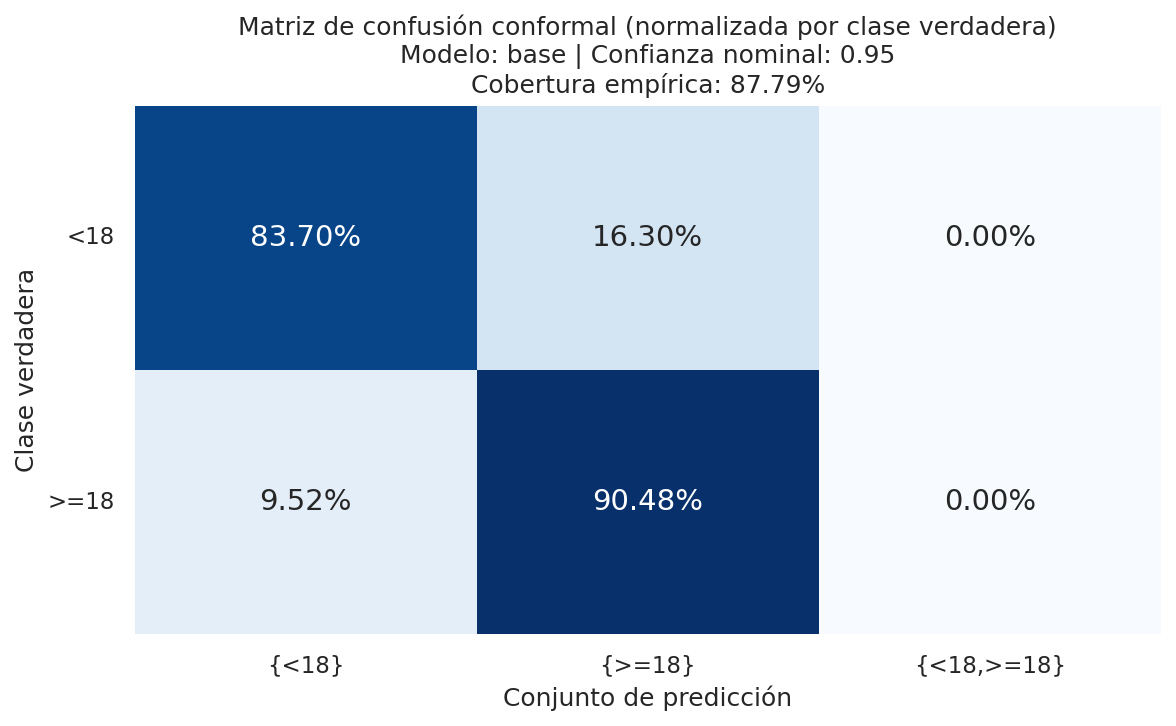

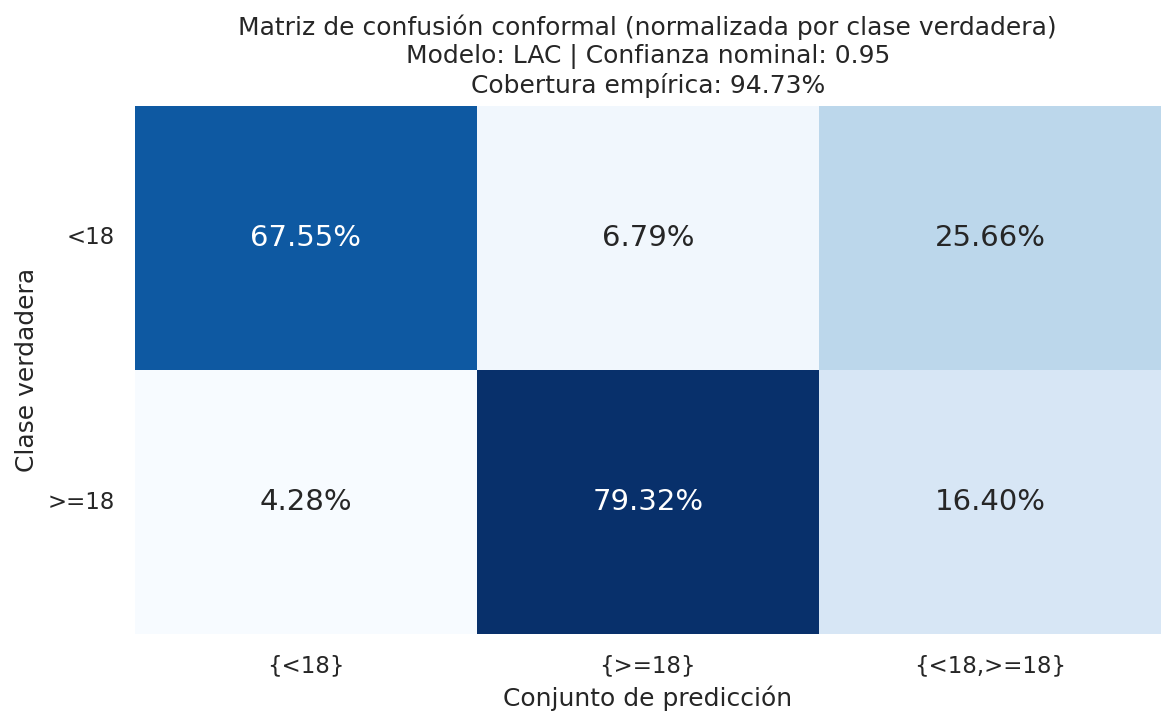

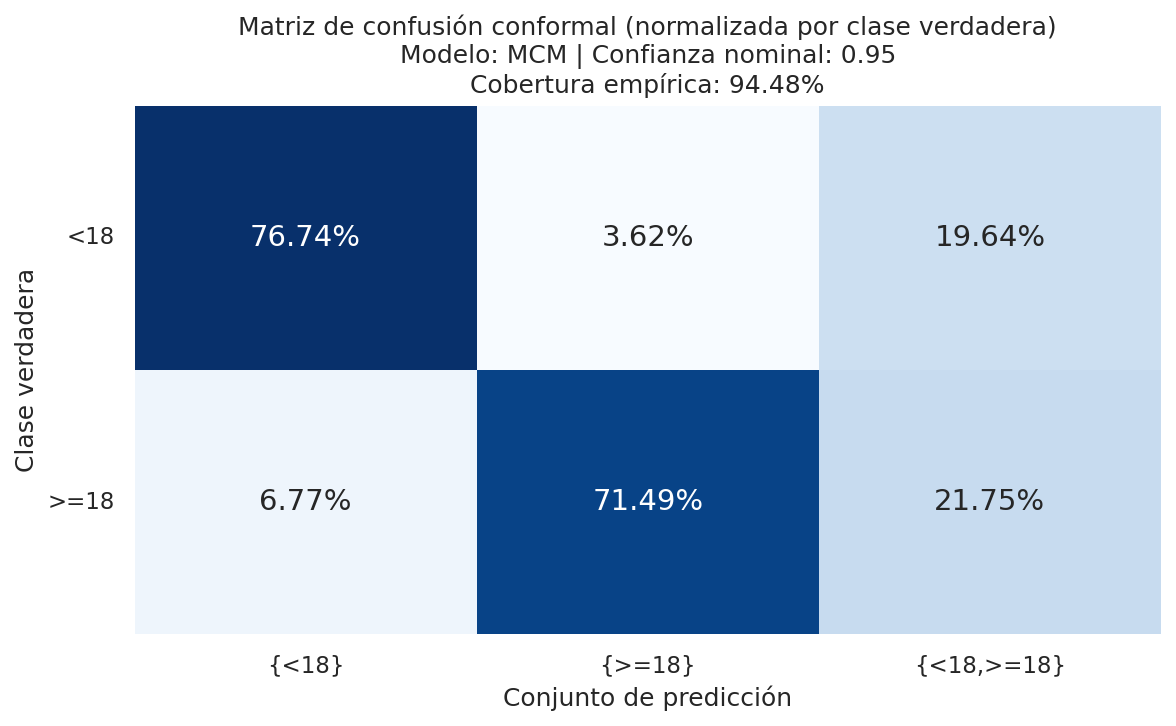

In [38]:
# Dibujar una matriz por cada combinación
for (model, conf), group in confusion_conformal.groupby(['pred_method', 'confidence']):
    # Crear tabla cruzada (confusion matrix)
    pivot = group.pivot(index='true_class', columns='pred_set_label', values='count').fillna(0)

    # Asegurar columnas en orden
    for label in pred_set_labels:
        if label not in pivot.columns:
            pivot[label] = 0
    pivot = pivot[pred_set_labels]

    # Normalizar por clase verdadera (por fila)
    pivot = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)
    # pivot = pivot.div(pivot.sum(axis=0), axis=1).fillna(0)

    # Obtener cobertura
    coverage = coverage_dict.get((model, conf), None)
    coverage_str = f'{coverage:.2%}' if coverage is not None else 'N/A'

    # Plot
    plt.figure(figsize=(8, 5), dpi=150)
    # sns.heatmap(pivot, annot=True, fmt='.2%', cmap='Blues', cbar=False, annot_kws={"size": 14})
    sns.heatmap(pivot, annot=True, fmt='.2%',cmap='Blues', cbar=False, annot_kws={"size": 14})
    plt.title(f'Matriz de confusión conformal (normalizada por clase verdadera)\nModelo: {model} | Confianza nominal: {conf}\n' +
              f'Cobertura empírica: {coverage_str}')
    plt.xlabel('Conjunto de predicción', fontsize=12)
    plt.ylabel('Clase verdadera', fontsize=12)
    plt.yticks([0.5, 1.5], ['<18', '>=18'], rotation=0)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# PROBLEMA 3: ESTIMACIÓN DE EDAD COMO PROBLEMA DE CLASIFICACIÓN

## 3.1. Carga de datos

In [39]:
# Carga de datos
df_AC_by_instance = pd.read_csv('results/III_AC_maxillofacial_test_results.csv')

# Nueva columna: cobertura (true/false)
df_AC_by_instance['well_classified'] = (df_AC_by_instance['true_class'] == df_AC_by_instance['pred_class'])

# Nueva columna: cobertura (true/false) 
df_AC_by_instance['is_covered'] = (
    ((df_AC_by_instance['true_class'] ==  0) & (df_AC_by_instance['pred_set_14'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  1) & (df_AC_by_instance['pred_set_15'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  2) & (df_AC_by_instance['pred_set_16'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  3) & (df_AC_by_instance['pred_set_17'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  4) & (df_AC_by_instance['pred_set_18'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  5) & (df_AC_by_instance['pred_set_19'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  6) & (df_AC_by_instance['pred_set_20'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  7) & (df_AC_by_instance['pred_set_21'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  8) & (df_AC_by_instance['pred_set_22'] == 1)) |
    ((df_AC_by_instance['true_class'] ==  9) & (df_AC_by_instance['pred_set_23'] == 1)) |
    ((df_AC_by_instance['true_class'] == 10) & (df_AC_by_instance['pred_set_24'] == 1)) |
    ((df_AC_by_instance['true_class'] == 11) & (df_AC_by_instance['pred_set_25'] == 1)) |
    ((df_AC_by_instance['true_class'] == 12) & (df_AC_by_instance['pred_set_26'] == 1))
)

# Nueva columna: tamaño del conjunto de predicción
df_AC_by_instance['pred_set_size'] = (
    df_AC_by_instance['pred_set_14'] + df_AC_by_instance['pred_set_15'] + 
    df_AC_by_instance['pred_set_16'] + df_AC_by_instance['pred_set_17'] + 
    df_AC_by_instance['pred_set_18'] + df_AC_by_instance['pred_set_19'] + 
    df_AC_by_instance['pred_set_20'] + df_AC_by_instance['pred_set_21'] + 
    df_AC_by_instance['pred_set_22'] + df_AC_by_instance['pred_set_23'] + 
    df_AC_by_instance['pred_set_24'] + df_AC_by_instance['pred_set_25'] + 
    df_AC_by_instance['pred_set_26'] 
)

# Nueva columna: set score
alpha = 1 - df_AC_by_instance['confidence']
df_AC_by_instance['set_score'] = (df_AC_by_instance['pred_set_size'] +
                                    1/alpha * (~df_AC_by_instance['is_covered']))

# Nueva columna: error absoluto medio
df_AC_by_instance['absolute_error'] = (
    df_AC_by_instance['true_class'] - df_AC_by_instance['pred_class']
).abs()

# Ordenar por iteración y por tipo de predicción
custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS', 'SAPS']
df_AC_by_intance = sort_by_column(df_AC_by_instance, 'pred_method', custom_order, 
                                    secondary_column='iteration')

display(df_AC_by_instance)

pred_method  confidence  iteration  pred_class  pred_set_14  \
0              LAC        0.95          1          11            0   
1              LAC        0.95          1           6            0   
2              LAC        0.95          1           1            1   
3              LAC        0.95          1           6            0   
4              LAC        0.95          1           6            0   
...            ...         ...        ...         ...          ...   
129115        base        0.95         10           4            1   
129116        base        0.95         10           2            1   
129117        base        0.95         10           6            1   
129118        base        0.95         10           2            1   
129119        base        0.95         10           7            1   

        pred_set_15  pred_set_16  pred_set_17  pred_set_18  pred_set_19  ...  \
0                 0            0            0            0            0  ...   
1                 0            0            1            1            1  ...   
2                 1            1            1            0            0  ...   
3                 0            0            1            1            1  ...   
4                 0            0            0            1            1  ...   
...             ...          ...          ...          ...          ...  ...   
129115            1            1            1            1            1  ...   
129116            1            1            1            1            1  ...   
129117            1            1            1            1            1  ...   
129118            1            1            1            1            1  ...   
129119            1            1            1            1            1  ...   

        pred_set_24  pred_set_25  pred_set_26  true_class  sex  \
0                 1            1            0          11    F   
1                 0            0            0           7    M   
2                 0            0            0           0    F   
3                 0            0            0           3    F   
4                 0            0            0           9    M   
...             ...          ...          ...         ...  ...   
129115            1            1            1           7    F   
129116            1            1            1           0    F   
129117            1            1            1           9    M   
129118            1            1            1           3    F   
129119            1            1            1           8    F   

        well_classified  is_covered  pred_set_size set_score  absolute_error  
0                  True        True              3       3.0               0  
1                 False        True              7       7.0               1  
2                 False        True              4       4.0               1  
3                 False        True              7       7.0               3  
4                 False        True              6       6.0               3  
...                 ...         ...            ...       ...             ...  
129115            False        True             13      13.0               3  
129116            False        True             13      13.0               2  
129117            False        True             13      13.0               3  
129118            False        True             13      13.0               1  
129119            False        True             13      13.0               1  

[129120 rows x 24 columns]

In [40]:
# Agrupar y calcular métricas
df_AC_by_run = (
    df_AC_by_instance
    .groupby(['pred_method', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AC_by_run)

/tmp/ipykernel_25759/1451266316.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'iteration'])
/tmp/ipykernel_25759/1451266316.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


pred_method  confidence  iteration  accuracy  empirical_coverage  \
0         base        0.95          1  0.274164            1.000000   
1         base        0.95          2  0.274164            1.000000   
2         base        0.95          3  0.287175            1.000000   
3         base        0.95          4  0.247212            1.000000   
4         base        0.95          5  0.307621            1.000000   
5         base        0.95          6  0.291822            1.000000   
6         base        0.95          7  0.261617            1.000000   
7         base        0.95          8  0.271375            1.000000   
8         base        0.95          9  0.292286            1.000000   
9         base        0.95         10  0.295074            1.000000   
10         LAC        0.95          1  0.258829            0.948885   
11         LAC        0.95          2  0.287175            0.949814   
12         LAC        0.95          3  0.266264            0.953996   
13         LAC        0.95          4  0.270911            0.950279   
14         LAC        0.95          5  0.273234            0.948420   
15         LAC        0.95          6  0.276952            0.942379   
16         LAC        0.95          7  0.282993            0.941450   
17         LAC        0.95          8  0.273699            0.942844   
18         LAC        0.95          9  0.278810            0.947491   
19         LAC        0.95         10  0.265335            0.958643   
20         MCM        0.95          1  0.258829            0.959572   
21         MCM        0.95          2  0.287175            0.952138   
22         MCM        0.95          3  0.266264            0.953532   
23         MCM        0.95          4  0.270911            0.959108   
24         MCM        0.95          5  0.273234            0.953532   
25         MCM        0.95          6  0.276952            0.950743   
26         MCM        0.95          7  0.282993            0.947955   
27         MCM        0.95          8  0.273699            0.948420   
28         MCM        0.95          9  0.278810            0.956784   
29         MCM        0.95         10  0.265335            0.960037   
30         APS        0.95          1  0.258829            0.946561   
31         APS        0.95          2  0.287175            0.940056   
32         APS        0.95          3  0.266264            0.942379   
33         APS        0.95          4  0.270911            0.947491   
34         APS        0.95          5  0.273234            0.942379   
35         APS        0.95          6  0.276952            0.945167   
36         APS        0.95          7  0.282993            0.935409   
37         APS        0.95          8  0.273699            0.933086   
38         APS        0.95          9  0.278810            0.947491   
39         APS        0.95         10  0.265335            0.948885   
40        RAPS        0.95          1  0.258829            0.951208   
41        RAPS        0.95          2  0.287175            0.940985   
42        RAPS        0.95          3  0.266264            0.942844   
43        RAPS        0.95          4  0.270911            0.941450   
44        RAPS        0.95          5  0.273234            0.942379   
45        RAPS        0.95          6  0.276952            0.948885   
46        RAPS        0.95          7  0.282993            0.936803   
47        RAPS        0.95          8  0.273699            0.934015   
48        RAPS        0.95          9  0.278810            0.948885   
49        RAPS        0.95         10  0.265335            0.957714   
50        SAPS        0.95          1  0.258829            0.952602   
51        SAPS        0.95          2  0.287175            0.953532   
52        SAPS        0.95          3  0.266264            0.953067   
53        SAPS        0.95          4  0.270911            0.952602   
54        SAPS        0.95          5  0.273234            0.955390   
55        SAPS        0.95 

## 3.2. Análisis de las métricas para la clasificación puntual 

In [43]:
# # Pivota para tener todas las métricas en columnas multi-nivel
# pivot_point_metrics = df_AC_by_run.pivot(
#     index='iteration',
#     columns=['pred_method', 'confidence'],
#     values=['mean_absolute_error'] 
# )

# # Reorganiza niveles para que las métricas estén en el nivel superior
# pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

# # Calcular la media por método para cada métrica
# pivot_point_with_mean = pd.concat([
#     pivot_point_metrics,
#     pivot_point_metrics.mean().to_frame().T.rename(index={0: 'Media'})
# ])

# # Muestra con 2 decimales tanto MAE como MSE
# styled_table = pivot_point_with_mean.style.format("{:.2f}")
# show(styled_table, allow_html=True)

### Análisis de consecutividad

In [ ]:
# # Agrupar columnas del set de predicción
# pred_cols = [f"pred_set_{age}" for age in range(14, 27)]

# # Matriz original con solo las columnas pred_set
# X = df_AC_by_instance[pred_cols].to_numpy()

# # Añadir columna de ceros al inicio y al final
# X_ext = np.c_[np.zeros((X.shape[0], 1), dtype=int), X, np.zeros((X.shape[0], 1), dtype=int)]

# # Calcular diferencias fila a fila
# diffs = np.diff(X_ext, axis=1)

# # Contar inicios y finales de bloque en cada fila
# num_inicios = (diffs == 1).sum(axis=1)
# num_finales = (diffs == -1).sum(axis=1)

# # Un único bloque de 1s si hay exactamente 1 inicio y 1 final
# df_AC_by_instance["all_consecutive"] = (num_inicios == 1) & (num_finales == 1)

# display(df_AC_by_instance)

pred_method  confidence  iteration  pred_class  pred_set_14  \
0             base        0.95          1          11            0   
1             base        0.95          1           5            0   
2             base        0.95          1           0            1   
3             base        0.95          1           6            0   
4             base        0.95          1           8            0   
...            ...         ...        ...         ...          ...   
129115        SAPS        0.95         10           4            0   
129116        SAPS        0.95         10           3            1   
129117        SAPS        0.95         10           9            0   
129118        SAPS        0.95         10           3            1   
129119        SAPS        0.95         10           9            0   

        pred_set_15  pred_set_16  pred_set_17  pred_set_18  pred_set_19  ...  \
0                 0            0            0            0            0  ...   
1                 0            0            0            0            1  ...   
2                 0            0            0            0            0  ...   
3                 0            0            0            0            0  ...   
4                 0            0            0            0            0  ...   
...             ...          ...          ...          ...          ...  ...   
129115            0            1            1            1            1  ...   
129116            1            1            1            1            1  ...   
129117            0            0            0            0            1  ...   
129118            1            1            1            1            1  ...   
129119            0            0            0            0            1  ...   

        pred_set_25  pred_set_26  true_class  sex  well_classified  \
0                 1            0          11    F             True   
1                 0            0           7    M            False   
2                 0            0           0    F             True   
3                 0            0           3    F            False   
4                 0            0           9    M            False   
...             ...          ...         ...  ...              ...   
129115            0            0           7    F            False   
129116            0            0           0    F            False   
129117            1            0           9    M             True   
129118            0            0           3    F             True   
129119            1            0           8    F            False   

        is_covered  pred_set_size  set_score absolute_error  all_consecutive  
0             True              1        1.0              0             True  
1            False              1       21.0              2             True  
2             True              1        1.0              0             True  
3            False              1       21.0              3             True  
4            False              1       21.0              1             True  
...            ...            ...        ...            ...              ...  
129115        True              7        7.0              3             True  
129116        True              7        7.0              3             True  
129117        True              7        7.0              0             True  
129118        True              7        7.0              0             True  
129119        True              7        7.0              1             True  

[129120 rows x 25 columns]

In [44]:
# # Agrupar y calcular métricas
# df_AC_by_run_consecutivity = (
#     df_AC_by_instance
#     .groupby(['pred_method', 'confidence', 'iteration'])
#     .apply(lambda g: pd.Series({
#         'mean_consecutive_pred_set': g['all_consecutive'].mean()
#     }))
#     .reset_index()
# )

# display(df_AC_by_run_consecutivity)

In [45]:
# # Pivota para tener todas las métricas en columnas multi-nivel
# pivot_point_metrics_consecutivity= df_AC_by_run_consecutivity.pivot(
#     index='iteration',
#     columns=['pred_method', 'confidence'],
#     values=['mean_consecutive_pred_set'] 
# )

# # Reorganiza niveles para que las métricas estén en el nivel superior
# pivot_point_metrics_consecutivity = pivot_point_metrics_consecutivity.swaplevel(axis=1).sort_index(axis=1)

# # Calcular la media por método para cada métrica
# pivot_point_with_mean = pd.concat([
#     pivot_point_metrics_consecutivity,
#     pivot_point_metrics_consecutivity.mean().to_frame().T.rename(index={0: 'Media'})
# ])

# # Muestra con 2 decimales tanto MAE como MSE
# styled_table = pivot_point_with_mean.style.format("{:.2f}")
# show(styled_table, allow_html=True)

## 3.3.  Análisis de las métricas para la clasificación conformal

### Tabla resumen por método y ejecución

In [46]:
# Pivot, reorganiza métricas y añade medias
pivot_interval_metrics = (
    df_AC_by_run
    .pivot(
        index='iteration',
        columns=['pred_method', 'confidence'],
        values=['empirical_coverage', 'mean_set_size', 'mean_set_score']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Define el orden deseado de las métricas y reindexa las columnas según el orden especificado
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

# Multiplicar columnas de cobertura por 100 (selección por nivel)
pivot_interval_metrics.loc[:, pd.IndexSlice['empirical_coverage', :, :]] *= 100

# Añadimos fila de medias
pivot_interval_metrics.loc['Media'] = pivot_interval_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_interval_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de varianza

In [47]:
df_AC_by_run_for_stat_com = df_AC_by_run[df_AC_by_run['pred_method']!='base']
# df_AC_by_run_for_stat_com = df_AC_by_run_for_stat_com[df_AC_by_run_for_stat_com['pred_method']!='MCM']

for metric in ['empirical_coverage', 'mean_set_size']:
    run_group_comparison(df_AC_by_run_for_stat_com, metric)


ANÁLISIS ESTADÍSTICO PARA: EMPIRICAL_COVERAGE
• Normalidad (Shapiro-Wilk): p = 0.6174 ✅
• Homocedasticidad (Levene): p = 0.6742 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df              F         PR(>F)
C(pred_method)  44.992777   5.0  300947.803717  1.392814e-100
Residual         0.001346  45.0            NaN            NaN


🔎 Comparaciones por pares (Tukey HSD):


group1 group2  meandiff   p-adj   lower   upper  reject
0    APS    LAC    0.0055  0.1766 -0.0014  0.0125   False
1    APS    MCM    0.0113  0.0003  0.0043  0.0182    True
2    APS   RAPS    0.0016  0.9628 -0.0053  0.0086   False
3    APS   SAPS    0.0101  0.0014  0.0031  0.0170    True
4    LAC    MCM    0.0058  0.1465 -0.0012  0.0127   False
5    LAC   RAPS   -0.0039  0.5075 -0.0109  0.0030   False
6    LAC   SAPS    0.0046  0.3521 -0.0024  0.0115   False
7    MCM   RAPS   -0.0097  0.0024 -0.0166 -0.0027    True
8    MCM   SAPS   -0.0012  0.9875 -0.0082  0.0057   False
9   RAPS   SAPS    0.0085  0.0100  0.0015  0.0154    True


ANÁLISIS ESTADÍSTICO PARA: MEAN_SET_SIZE
• Normalidad (Shapiro-Wilk): p = 0.2465 ✅
• Homocedasticidad (Levene): p = 0.7704 ✅

📊 ANOVA clásico + Tukey HSD


sum_sq    df             F        PR(>F)
C(pred_method)  2049.985217   5.0  19876.732805  4.929322e-74
Residual           0.928214  45.0           NaN           NaN


🔎 Comparaciones por pares (Tukey HSD):


group1 group2  meandiff   p-adj   lower   upper  reject
0    APS    LAC   -0.1558  0.1271 -0.3383  0.0267   False
1    APS    MCM    1.5265  0.0000  1.3440  1.7090    True
2    APS   RAPS   -0.1403  0.2043 -0.3228  0.0422   False
3    APS   SAPS    0.1931  0.0333  0.0106  0.3756    True
4    LAC    MCM    1.6823  0.0000  1.4998  1.8648    True
5    LAC   RAPS    0.0155  0.9992 -0.1670  0.1980   False
6    LAC   SAPS    0.3489  0.0000  0.1664  0.5314    True
7    MCM   RAPS   -1.6668  0.0000 -1.8493 -1.4843    True
8    MCM   SAPS   -1.3335  0.0000 -1.5160 -1.1510    True
9   RAPS   SAPS    0.3334  0.0000  0.1509  0.5159    True

### Gráfica de dispersión Cobertura empírica - Tamaño medio del conjunto

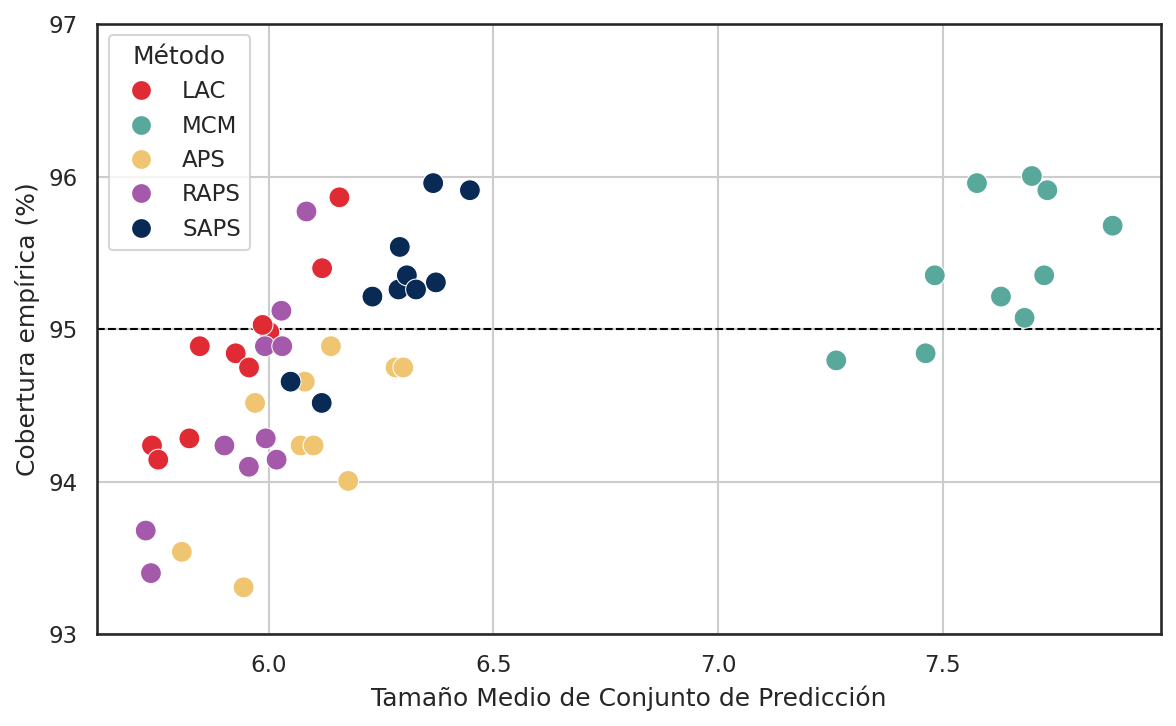

In [48]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}
df_AC_by_run_to_plot = df_AC_by_run[df_AC_by_run['pred_method']!='base'].copy()
# df_AGC_by_run_to_plot = df_AGC_by_run_to_plot[df_AGC_by_run_to_plot['pred_model_type'] != 'MCM']
df_AC_by_run_to_plot['color'] = df_AC_by_run_to_plot['pred_method'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AC_by_run_to_plot['empirical_coverage'],
    model_types=df_AC_by_run_to_plot['pred_method'],
    colors=df_AC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 3.4. Análisis de la cobertura por tamaño del conjunto de predicción

/tmp/ipykernel_25759/1252586063.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  coverage_matrix = df.pivot_table(
/tmp/ipykernel_25759/1252586063.py:93: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  count_matrix = df.pivot_table(


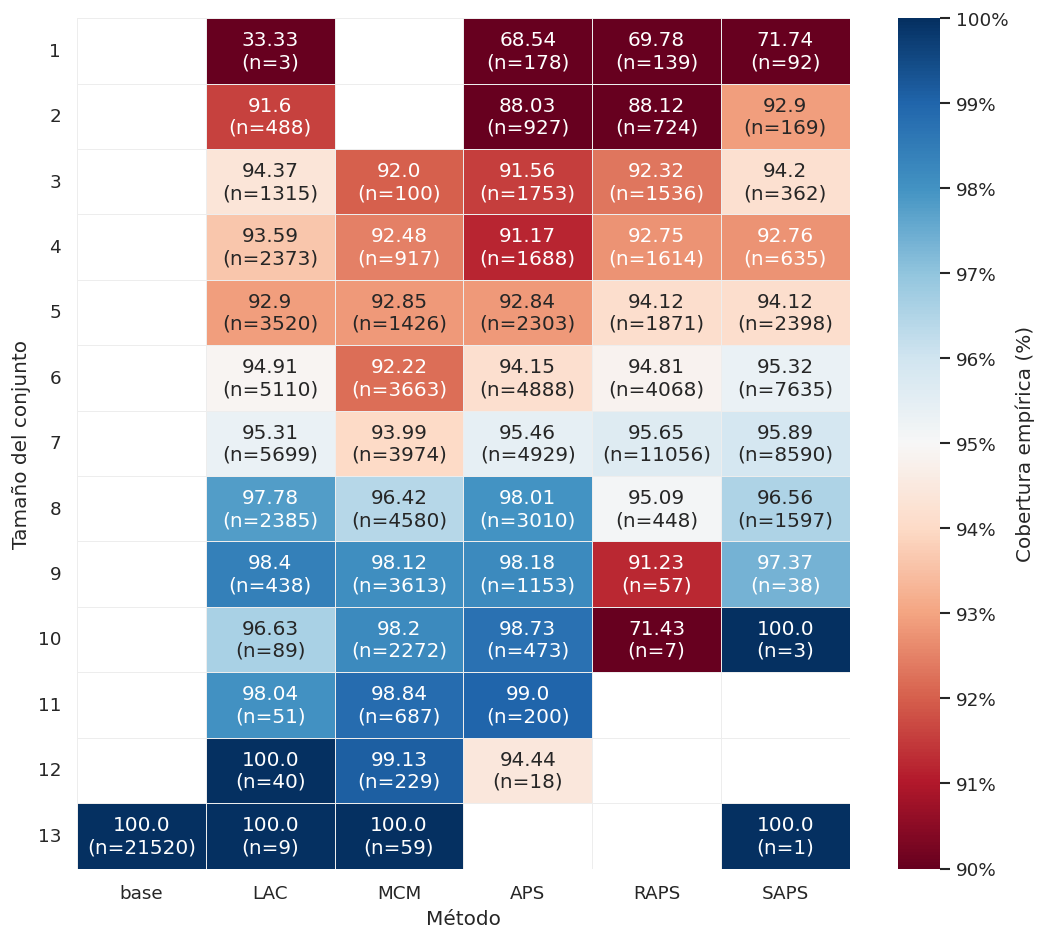

In [49]:
fig = plot_coverage_by_set_size(df_AC_by_instance, figsize=(9,8), dpi=120)
plt.show()

## 3.5. Análisis de la cobertura en función de la edad cronológica

### Tabla resumen de cobertura y tamaño medio del conjunto de predicción por edad cronológica

In [50]:
df_AC_by_instance_for_age = df_AC_by_instance.copy()
df_AC_by_instance_for_age['true_value_int'] = df_AC_by_instance_for_age['true_class'].astype(int)+14

# display(df_AGC_by_instance_for_age)

df_AC_by_true_age = (
    df_AC_by_instance_for_age
    .groupby(['pred_method', 'confidence','true_value_int'])
    .agg(
        empirical_coverage=('is_covered', 'mean'),
        mean_set_size=('pred_set_size', 'mean')
    )
    .reset_index()
)

# Pivota para tener todas las métricas en columnas multi-nivel
df_AC_by_true_age = df_AC_by_true_age.pivot(
    index='true_value_int',
    columns=['pred_method', 'confidence'],
    values=['empirical_coverage', 'mean_set_size'] 
)

# Multiplica columnas de cobertura por 100
coverage_cols = [col for col in df_AC_by_true_age.columns if 'empirical_coverage' in str(col)]
df_AC_by_true_age[coverage_cols] = df_AC_by_true_age[coverage_cols] * 100

# Muestra tabla con formato
styled_table = df_AC_by_true_age.style.format("{:.2f}")
show(styled_table, allow_html=True)

/tmp/ipykernel_25759/1684388054.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence','true_value_int'])


### Gráfica

In [51]:
df_AC_coverage_by_age = df_AC_by_instance.copy()

#
df_AC_coverage_by_age['true_value_int'] = df_AC_coverage_by_age['true_class'].astype(int)+14

# Calcula la cobertura empírica por edad en entero
df_AC_coverage_by_age = df_AC_coverage_by_age.groupby(
    ['pred_method', 'confidence', 'true_value_int']
).agg(
    mean_coverage=('is_covered', 'mean'),  # % de cobertura empírica
    mean_set_size=('pred_set_size', 'mean'),  # Ancho promedio del intervalo en el decil
    count=('is_covered', 'count')  # Número de muestras en el decil
).reset_index()

df_AC_coverage_by_age['mean_coverage'] = (df_AC_coverage_by_age['mean_coverage'] * 100)

df_AC_coverage_by_age = df_AC_coverage_by_age[
    df_AC_coverage_by_age['pred_method'].str.strip().str.lower() != 'base'
]

# Si es categoría, eliminarla del dtype
if pd.api.types.is_categorical_dtype(df_AC_coverage_by_age['pred_method']):
    df_AC_coverage_by_age['pred_method'] = df_AC_coverage_by_age['pred_method'].cat.remove_unused_categories()

display(df_AC_coverage_by_age)


/tmp/ipykernel_25759/165947923.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_AC_coverage_by_age = df_AC_coverage_by_age.groupby(
/tmp/ipykernel_25759/165947923.py:22: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_AC_coverage_by_age['pred_method']):


pred_method  confidence  true_value_int  mean_coverage  mean_set_size  \
12         LAC        0.95              14      97.326733       3.610891   
13         LAC        0.95              15      94.386792       4.460849   
14         LAC        0.95              16      97.608696       5.321739   
15         LAC        0.95              17      96.842105       5.804785   
16         LAC        0.95              18      93.349515       6.188350   
17         LAC        0.95              19      95.973451       6.773009   
18         LAC        0.95              20      95.700483       6.923671   
19         LAC        0.95              21      95.784314       7.063235   
20         LAC        0.95              22      92.694611       6.913174   
21         LAC        0.95              23      92.261905       6.710714   
22         LAC        0.95              24      86.049383       5.793827   
23         LAC        0.95              25      88.000000       5.520000   
24         MCM        0.95              14      96.188119       5.560891   
25         MCM        0.95              15      93.537736       6.333491   
26         MCM        0.95              16      97.391304       7.023043   
27         MCM        0.95              17      94.688995       7.426316   
28         MCM        0.95              18      90.728155       7.862136   
29         MCM        0.95              19      97.345133       8.561947   
30         MCM        0.95              20      95.700483       8.688889   
31         MCM        0.95              21      96.372549       8.738725   
32         MCM        0.95              22      92.994012       8.505988   
33         MCM        0.95              23      96.845238       8.091667   
34         MCM        0.95              24      97.901235       7.028395   
35         MCM        0.95              25     100.000000       6.645000   
36         APS        0.95              14      97.574257       3.345545   
37         APS        0.95              15      93.443396       4.407075   
38         APS        0.95              16      96.086957       5.511304   
39         APS        0.95              17      94.736842       6.115789   
40         APS        0.95              18      92.766990       6.483981   
41         APS        0.95              19      96.106195       7.053097   
42         APS        0.95              20      94.782609       7.143961   
43         APS        0.95              21      95.931373       7.357353   
44         APS        0.95              22      92.395210       7.158084   
45         APS        0.95              23      91.488095       6.935119   
46         APS        0.95              24      86.543210       5.676543   
47         APS        0.95              25      91.500000       5.340000   
48        RAPS        0.95              14      97.871287       3.581188   
49        RAPS        0.95              15      94.292453       4.634906   
50        RAPS        0.95              16      96.086957       5.595217   
51        RAPS        0.95              17      95.215311       6.140191   
52        RAPS        0.95              18      93.543689       6.416505   
53        RAPS        0.95              19      96.681416       6.738938   
54        RAPS        0.95              20      95.893720       6.800000   
55        RAPS        0.95              21      96.323529       6.850980   
56        RAPS        0.95              22      92.874251       6.728743   
57        RAPS        0.95              23      90.892857       6.520833   
58        RAPS        0.95              24      84.197531       5.534568   
59        RAPS        0.95              25      82.000000       5.090000   
60        SAPS        0.95              14      97.376238       4.933663   
61        SAPS        0.95              15      94.528302       5.646698   
62        SAPS        0.95              16      97.652174       6.099565   
63        SAPS        0.95              17      97.

/tmp/ipykernel_25759/3082041407.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


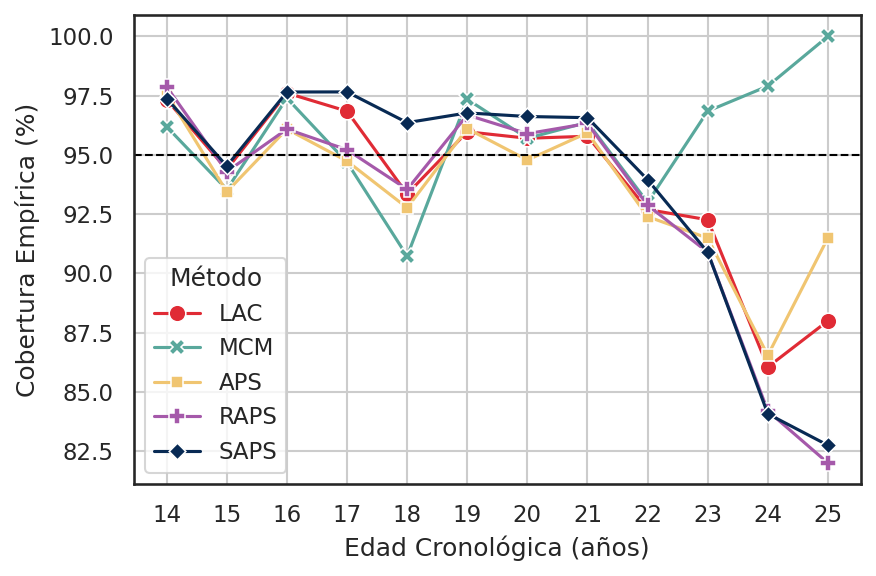

In [52]:
# df_AC_coverage_by_age = df_AC_coverage_by_age[df_AC_coverage_by_age['pred_model_type']!='MCM']

plt.figure(figsize=(6, 4), dpi=150)

color_dict = {'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}

lineplot = sns.lineplot(
    data=df_AC_coverage_by_age,
    x='true_value_int',
    y='mean_coverage',
    hue='pred_method',
    style='pred_method',
    markers=True,
    dashes=False,
    palette=color_dict,
    ci=None  # si quieres puedes calcular intervalo de confianza, sino None para evitarlo
)

# Cambiar el tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)  # Ajusta el número a tu preferencia

plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Cobertura Empírica (%)')
plt.legend(title='Método')
plt.grid(True)

plt.xticks(range(df_AC_coverage_by_age['true_value_int'].min(),
                 df_AC_coverage_by_age['true_value_int'].max() + 1, 1))

plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_25759/2084246331.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


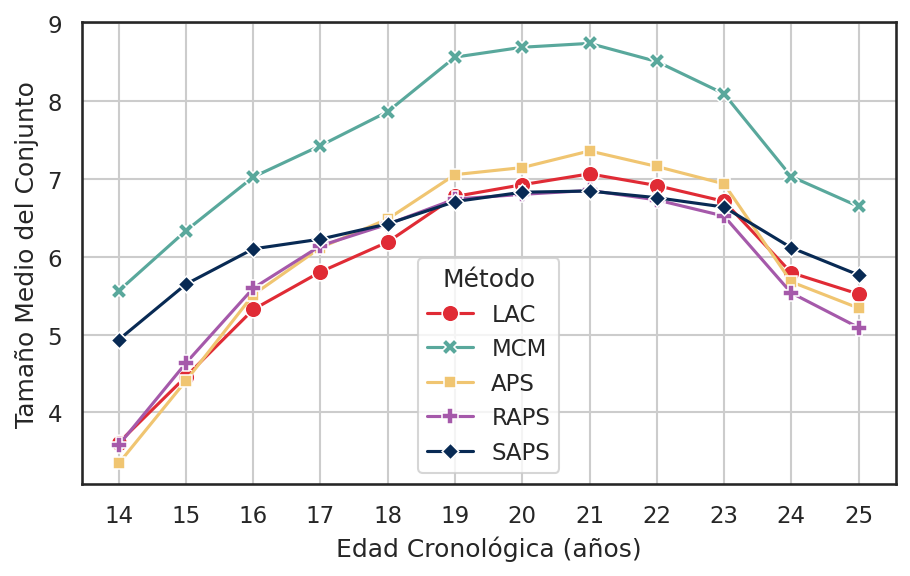

In [53]:
plt.figure(figsize=(7, 4), dpi=150)
lineplot = sns.lineplot(
    data=df_AC_coverage_by_age,
    x='true_value_int',
    y='mean_set_size',
    hue='pred_method',
    style='pred_method',
    markers=True,
    dashes=False,
    ci=None,
    palette=color_dict
)
# Cambiar el tamaño de los marcadores
plt.setp(lineplot.lines, markersize=8)  # Ajusta el número a tu preferencia

plt.xlabel('Edad Cronológica (años)')
plt.ylabel('Tamaño Medio del Conjunto')
plt.xticks(range(int(df_AC_coverage_by_age['true_value_int'].min()), 
                 int(df_AC_coverage_by_age['true_value_int'].max()) + 1, 1))

plt.legend(title='Método')
plt.grid(True)
plt.show()

## 3.6. Análisis de la cobertura en función de la edad cronológica y el sexo

In [54]:
# Agrupar y calcular métricas por ejecución
df_AC_by_run_with_sex = (
    df_AC_by_instance
    .groupby(['pred_method', 'confidence', 'iteration', 'sex'])
    .agg(
        empirical_coverage=('is_covered', 'mean'),
        mean_set_size=('pred_set_size', 'mean')
    )
    .reset_index()
)

# Ordena por iteración y por tipo de predicción
df_AC_by_run_with_sex = sort_by_column(df_AC_by_run_with_sex, 'pred_method', custom_order, secondary_column='iteration')

display(df_AC_by_run_with_sex)

/tmp/ipykernel_25759/3439336099.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_method', 'confidence', 'iteration', 'sex'])


pred_method  confidence  iteration sex  empirical_coverage  mean_set_size
0          base        0.95          1   F            1.000000      13.000000
1          base        0.95          1   M            1.000000      13.000000
2          base        0.95          2   F            1.000000      13.000000
3          base        0.95          2   M            1.000000      13.000000
4          base        0.95          3   F            1.000000      13.000000
..          ...         ...        ...  ..                 ...            ...
115        SAPS        0.95          8   M            0.964286       6.218367
116        SAPS        0.95          9   F            0.950512       6.466724
117        SAPS        0.95          9   M            0.969388       6.425510
118        SAPS        0.95         10   F            0.953072       6.397611
119        SAPS        0.95         10   M            0.967347       6.328571

[120 rows x 6 columns]

In [64]:
# Agrupar por método, confianza, sexo y edad entera
df_AC_coverage_by_age_sex = (
    df_AC_by_instance.assign(true_value_int=df_AC_by_instance['true_class'].astype(int))
    .groupby(['sex', 'pred_method', 'confidence', 'true_value_int'])
    .agg(
        mean_coverage=('is_covered', lambda x: round(x.mean() * 100, 2)),
        mean_set_size=('pred_set_size', lambda x: round(x.mean(), 2)),
        count=('is_covered', 'count')
    )
    .reset_index()
)

df_AC_coverage_by_age_sex['true_value_int'] = df_AC_coverage_by_age_sex['true_value_int']+14

df_AC_coverage_by_age_sex 

/tmp/ipykernel_25759/2412248096.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sex', 'pred_method', 'confidence', 'true_value_int'])


sex pred_method  confidence  true_value_int  mean_coverage  mean_set_size  \
0     F        base        0.95              14         100.00          13.00   
1     F        base        0.95              15         100.00          13.00   
2     F        base        0.95              16         100.00          13.00   
3     F        base        0.95              17         100.00          13.00   
4     F        base        0.95              18         100.00          13.00   
..   ..         ...         ...             ...            ...            ...   
139   M        SAPS        0.95              21          95.73           6.81   
140   M        SAPS        0.95              22          97.84           6.75   
141   M        SAPS        0.95              23          92.41           6.63   
142   M        SAPS        0.95              24          81.85           6.25   
143   M        SAPS        0.95              25          86.47           5.70   

     count  
0     1110  
1     1070  
2     1280  
3     1110  
4     1140  
..     ...  
139    960  
140    740  
141    830  
142    270  
143    170  

[144 rows x 7 columns]

In [65]:
# Pivot, reorganiza métricas y añade medias
pivot_interval_metrics = (
    df_AC_coverage_by_age_sex
    .pivot(
        index='true_value_int',
        columns=['sex', 'pred_method', 'confidence'],
        values=['mean_coverage', 'mean_set_size']
    )
    .swaplevel(axis=1)
    .sort_index(axis=1)
)

# Añadimos fila de medias
pivot_interval_metrics.loc['Media'] = pivot_interval_metrics.mean()

# Mostrar tabla con 2 decimales
styled_table = pivot_interval_metrics.style.format("{:.2f}")
show(styled_table, allow_html=True)

In [66]:

df_AC_coverage_by_age_sex = df_AC_coverage_by_age_sex[df_AC_coverage_by_age_sex['pred_method']!='base']
df_AC_coverage_by_age_sex['pred_method'] = df_AC_coverage_by_age_sex['pred_method'].cat.remove_unused_categories()
df_AC_coverage_by_age_sex['pred_method'].unique()

/tmp/ipykernel_25759/726511985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AC_coverage_by_age_sex['pred_method'] = df_AC_coverage_by_age_sex['pred_method'].cat.remove_unused_categories()


['LAC', 'MCM', 'APS', 'RAPS', 'SAPS']
Categories (5, object): ['LAC' < 'MCM' < 'APS' < 'RAPS' < 'SAPS']

/tmp/ipykernel_25759/3631189204.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


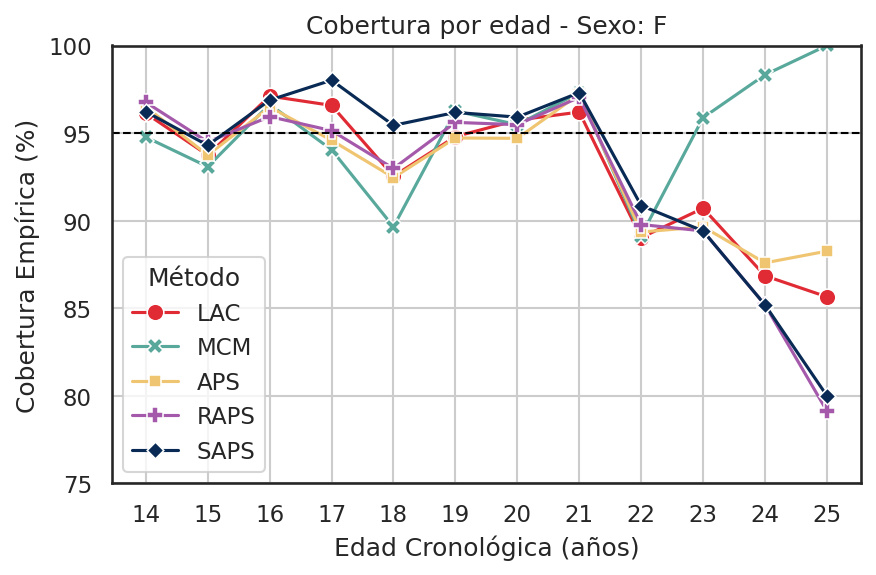

/tmp/ipykernel_25759/3631189204.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


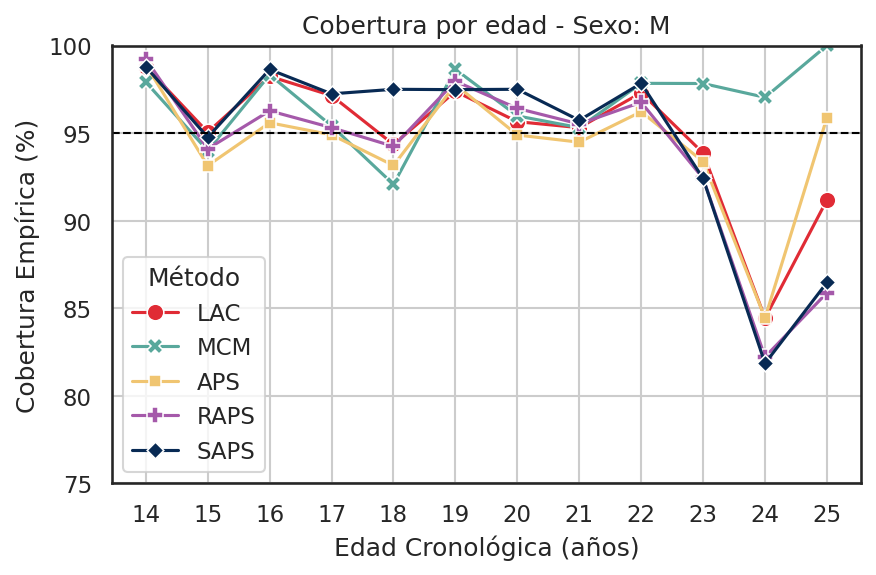

In [69]:

# Colores por método
color_dict = {'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}

# Crear un gráfico por sexo
sexes = df_AC_coverage_by_age_sex['sex'].unique()

for s in sexes:
    plt.figure(figsize=(6, 4), dpi=150)
    
    subset = df_AC_coverage_by_age_sex[df_AC_coverage_by_age_sex['sex'] == s]
    
    lineplot = sns.lineplot(
        data=subset,
        x='true_value_int',
        y='mean_coverage',
        hue='pred_method',
        style='pred_method',
        markers=True,
        dashes=False,
        palette=color_dict,
        ci=None
    )

    # Ajuste del tamaño de los marcadores
    plt.setp(lineplot.lines, markersize=8)

    # Etiquetas y estilo
    plt.xlabel('Edad Cronológica (años)')
    plt.ylabel('Cobertura Empírica (%)')
    plt.title(f'Cobertura por edad - Sexo: {s}')
    plt.legend(title='Método')
    plt.grid(True)

    # Ticks del eje X por cada año
    plt.xticks(range(subset['true_value_int'].min(),
                     subset['true_value_int'].max() + 1, 1))

    # Línea de referencia para cobertura objetivo (ej. 95%)
    plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)
    
    # Establecer rango del eje Y entre 60 y 100
    plt.ylim(75, 100)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_25759/566573815.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


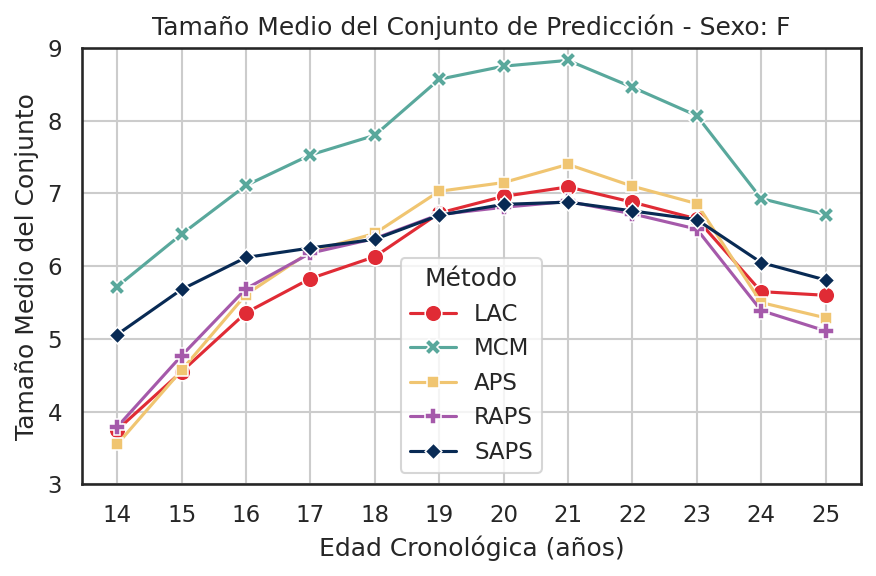

/tmp/ipykernel_25759/566573815.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


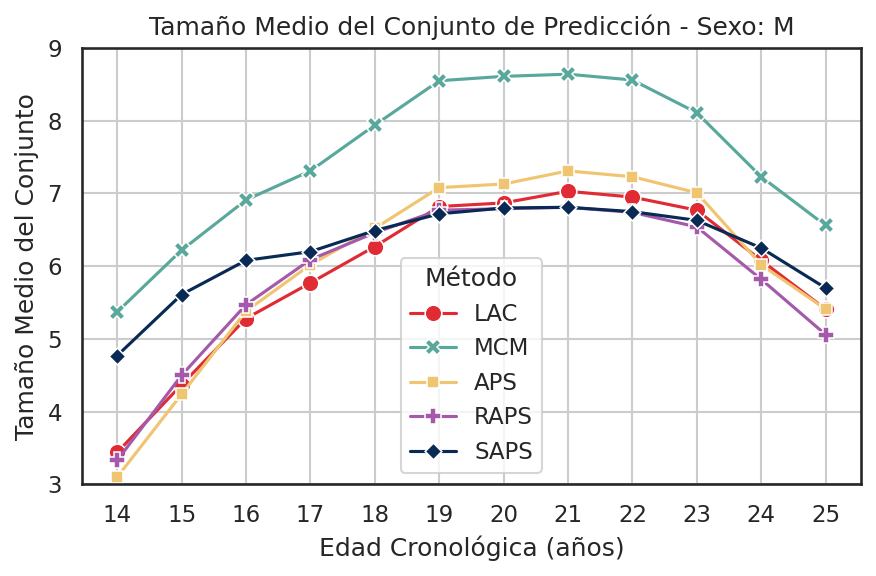

In [68]:
# Colores por método
color_dict = {'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}

# Crear un gráfico por sexo
sexes = df_AE_coverage_by_age_sex['sex'].unique()

for s in sexes:
    plt.figure(figsize=(6, 4), dpi=150)
    
    subset = df_AC_coverage_by_age_sex[df_AC_coverage_by_age_sex['sex'] == s]
    
    lineplot = sns.lineplot(
        data=subset,
        x='true_value_int',
        y='mean_set_size',
        hue='pred_method',
        style='pred_method',
        markers=True,
        dashes=False,
        palette=color_dict,
        ci=None
    )

    # Ajuste del tamaño de los marcadores
    plt.setp(lineplot.lines, markersize=8)

    # Etiquetas y estilo
    plt.xlabel('Edad Cronológica (años)')
    plt.ylabel('Tamaño Medio del Conjunto')
    plt.title(f'Tamaño Medio del Conjunto de Predicción - Sexo: {s}')
    plt.legend(title='Método')
    plt.grid(True)

    # Ticks del eje X por cada año
    plt.xticks(range(subset['true_value_int'].min(),
                     subset['true_value_int'].max() + 1, 1))

    # Línea de referencia para cobertura objetivo (ej. 95%)
    plt.axhline(y=95, color='black', linestyle='--', linewidth=1.0, zorder=2)
    
    # Establecer rango del eje Y entre 60 y 100
    plt.ylim(3, 9)

    plt.tight_layout()
    plt.show()

# PROBLEMA 4: ESTIMACIÓN DE SEXO

## 4.1. Carga de datos

In [10]:
# Carga de datos
df_SE_by_instance = pd.read_csv('results/IV_SC_maxillofacial_test_results.csv')

# # Nueva columna: cobertura (true/false)
# df_AMSC_by_instance['well_classified'] = (
#     df_AMSC_by_instance['true_class'] == df_AMSC_by_instance['pred_class']
# )

# # Nueva columna: cobertura (true/false)
# df_AMSC_by_instance['is_covered'] = (
#     ((df_AMSC_by_instance['true_class'] == 0) & (df_AMSC_by_instance['pred_set_male_under_18']   == 1)) |
#     ((df_AMSC_by_instance['true_class'] == 1) & (df_AMSC_by_instance['pred_set_male_over_18']    == 1)) |
#     ((df_AMSC_by_instance['true_class'] == 2) & (df_AMSC_by_instance['pred_set_female_under_18'] == 1)) |
#     ((df_AMSC_by_instance['true_class'] == 3) & (df_AMSC_by_instance['pred_set_female_over_18']  == 1))
# )

# # Nueva columna: tamaño del conjunto de predicción
# df_AMSC_by_instance['pred_set_size'] = (
#     df_AMSC_by_instance['pred_set_male_under_18'] 
#     + df_AMSC_by_instance['pred_set_male_over_18']
#     + df_AMSC_by_instance['pred_set_female_under_18'] 
#     + df_AMSC_by_instance['pred_set_female_over_18']
# )

# # Nueva columna: set score
# alpha = 1 - df_AMSC_by_instance['confidence']
# df_AMSC_by_instance['set_score'] = (df_AMSC_by_instance['pred_set_size'] +
#                                     1/alpha * (~df_AMSC_by_instance['is_covered']))

# # Ordenar por iteración y por tipo de predicción
# custom_order = ['base', 'LAC', 'MCM', 'APS', 'RAPS', 'SAPS']
# df_AMSC_by_intance = sort_by_column(df_AMSC_by_instance, 'pred_model_type', custom_order, 
#                                     secondary_column='iteration')

# display(df_AMSC_by_instance)

EmptyDataError: No columns to parse from file

In [33]:
# Agrupar y calcular métricas
df_AMSC_by_run = (
    df_AMSC_by_instance
    .groupby(['pred_model_type', 'confidence', 'iteration'])
    .apply(lambda g: pd.Series({
        'accuracy': g['well_classified'].mean(),
        'empirical_coverage': g['is_covered'].mean(),
        'mean_set_size': g['pred_set_size'].mean(),
        'mean_set_score': g['set_score'].mean()
    }))
    .reset_index()
)

display(df_AMSC_by_run)

/tmp/ipykernel_9900/1060119993.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['pred_model_type', 'confidence', 'iteration'])
/tmp/ipykernel_9900/1060119993.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


pred_model_type  confidence  iteration  accuracy  empirical_coverage  \
0             base        0.95          1  0.777881            0.777881   
1             base        0.95          2  0.764870            0.764870   
2             base        0.95          3  0.763476            0.763476   
3             base        0.95          4  0.752323            0.752323   
4             base        0.95          5  0.749535            0.749535   
5             base        0.95          6  0.763941            0.763941   
6             base        0.95          7  0.760688            0.760688   
7             base        0.95          8  0.744424            0.744424   
8             base        0.95          9  0.759294            0.759294   
9             base        0.95         10  0.744424            0.744424   
10             LAC        0.95          1  0.761152            0.944703   
11             LAC        0.95          2  0.760223            0.950743   
12             LAC        0.95          3  0.730483            0.941914   
13             LAC        0.95          4  0.723978            0.947491   
14             LAC        0.95          5  0.756506            0.936803   
15             LAC        0.95          6  0.730483            0.941914   
16             LAC        0.95          7  0.751394            0.934944   
17             LAC        0.95          8  0.757900            0.940056   
18             LAC        0.95          9  0.757900            0.940056   
19             LAC        0.95         10  0.761152            0.944703   
20             MCM        0.95          1  0.761152            0.952602   
21             MCM        0.95          2  0.760223            0.947955   
22             MCM        0.95          3  0.730483            0.948420   
23             MCM        0.95          4  0.723978            0.947955   
24             MCM        0.95          5  0.756506            0.938197   
25             MCM        0.95          6  0.730483            0.948420   
26             MCM        0.95          7  0.751394            0.937268   
27             MCM        0.95          8  0.757900            0.944238   
28             MCM        0.95          9  0.757900            0.944238   
29             MCM        0.95         10  0.761152            0.952602   
30             APS        0.95          1  0.751859            0.942379   
31             APS        0.95          2  0.760223            0.943309   
32             APS        0.95          3  0.730483            0.930762   
33             APS        0.95          4  0.723978            0.934480   
34             APS        0.95          5  0.756506            0.943773   
35             APS        0.95          6  0.730483            0.930762   
36             APS        0.95          7  0.751394            0.945632   
37             APS        0.95          8  0.757900            0.939126   
38             APS        0.95          9  0.757900            0.939126   
39             APS        0.95         10  0.761152            0.950279   
40            RAPS        0.95          1  0.751859            0.939591   
41            RAPS        0.95          2  0.760223            0.939591   
42            RAPS        0.95          3  0.730483            0.927045   
43            RAPS        0.95          4  0.723978            0.933550   
44            RAPS        0.95          5  0.756506            0.945632   
45            RAPS        0.95          6  0.730483            0.927045   
46            RAPS        0.95          7  0.751394            0.941450   
47            RAPS        0.95          8  0.757900            0.939126   
48            RAPS        0.95          9  0.757900            0.939126   
49            RAPS        0.95         10  0.761152            0.950279   
50            SAPS        0.95          1  0.761152            0.956320   
51            SAPS        0.95          2  0.760223            0.960502   
52            SAPS        0.

## 4.2. Análisis de las métricas para la clasificación puntual de mayoría de edad y sexo

### Tabla resumen por método y ejecución

In [6]:
# Pivota para tener todas las métricas en columnas multi-nivel
pivot_point_metrics = df_AMSC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['accuracy'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_point_metrics = pivot_point_metrics.swaplevel(axis=1).sort_index(axis=1)

In [7]:
# Calcular la media por método para cada métrica
pivot_point_with_mean = pd.concat([
    pivot_point_metrics,
    pivot_point_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Muestra con 2 decimales tanto MAE como MSE
styled_table = pivot_point_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de la varianza

## 4.3. Análisis de las métricas para la clasificación de mayoría de sexo y edad en conjunto de predicción

### Tabla resumen por método y ejecución

In [8]:
# Pivotea para tener todas las métricas en columnas multi-nivel
pivot_interval_metrics = df_AMSC_by_run.pivot(
    index='iteration',
    columns=['pred_model_type', 'confidence'],
    values=['empirical_coverage', 'mean_set_size', 'mean_set_score'] 
)

# Reorganiza niveles para que las métricas estén en el nivel superior
pivot_interval_metrics = pivot_interval_metrics.swaplevel(axis=1).sort_index(axis=1)

In [9]:
# Define el orden deseado de las métricas
metric_order = ['empirical_coverage', 'mean_set_size', 'mean_set_score'] 

# Reindexa las columnas según el orden especificado
pivot_interval_metrics = pivot_interval_metrics.reindex(columns=metric_order, level=0)

In [10]:
# Calcular la media por método para cada métrica
pivot_with_mean = pd.concat([
    pivot_interval_metrics,
    pivot_interval_metrics.mean().to_frame().T.rename(index={0: 'Media'})
])

# Multiplicar columnas de cobertura por 100
coverage_cols = [col for col in pivot_with_mean.columns if 'empirical_coverage' in str(col)]
pivot_with_mean[coverage_cols] = pivot_with_mean[coverage_cols] * 100

# Mostrar tabla con formato
styled_table = pivot_with_mean.style.format("{:.2f}")
show(styled_table, allow_html=True)

### Análisis de la varianza

### Gráfica de dispersión Cobertura empírica - Tamaño medio del conjunto

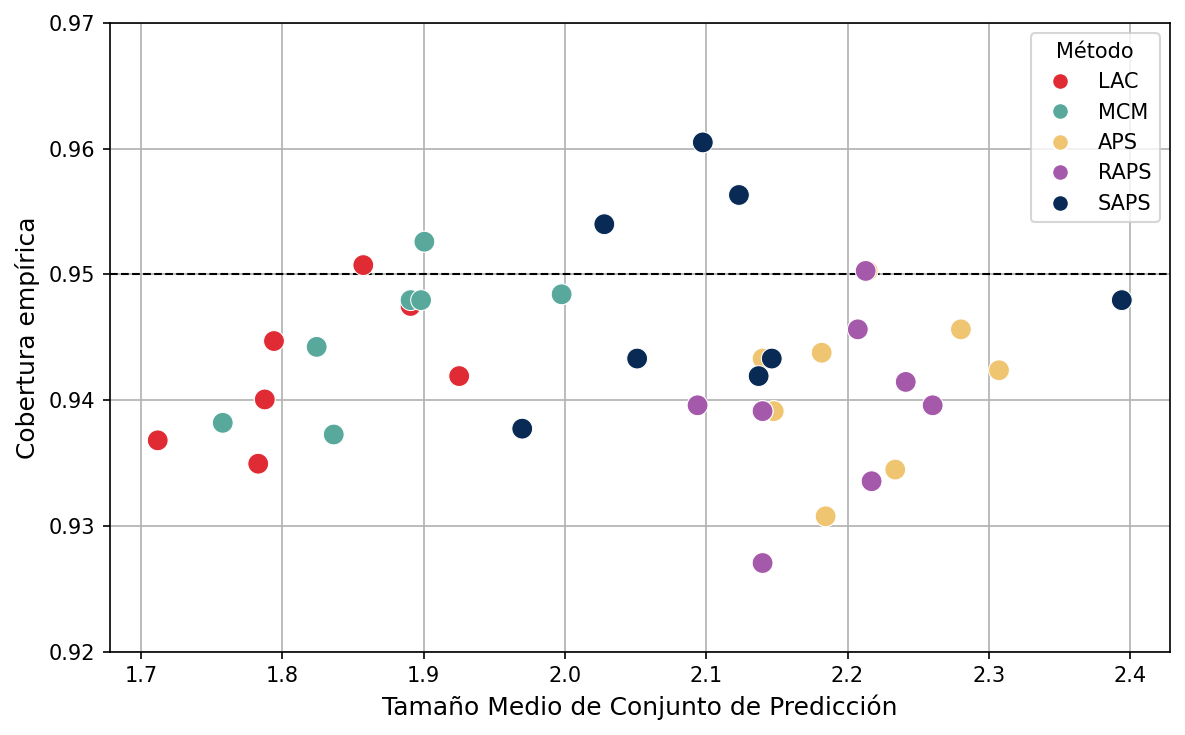

In [11]:
# Mapear colores
color_dict = {'base': '#7f7f7f', 'LAC': '#e02b35', 'MCM': '#59a89c', 
              'APS': '#f0c571', 'RAPS': '#a559aa', 'SAPS': '#082a54'}

df_AMSC_by_run_to_plot = df_AMSC_by_run[df_AMSC_by_run['pred_model_type']!='base'].copy()
# df_AMSC_by_run_to_plot = df_AMSC_by_run.copy()
df_AMSC_by_run_to_plot['color'] = df_AMSC_by_run_to_plot['pred_model_type'].map(color_dict)

#
plot_coverage_vs_set_size(
    mean_set_sizes=df_AMSC_by_run_to_plot['mean_set_size'],
    empirical_coverages=df_AMSC_by_run_to_plot['empirical_coverage'],
    model_types=df_AMSC_by_run_to_plot['pred_model_type'],
    colors=df_AMSC_by_run_to_plot['color'],
    confidence_level=0.95,
    figsize=(8, 5),
    dpi=150
)

## 4.4. Análisis de la cobertura por tamaño del conjunto de predicción

###  Tabla resumen de la cobertura por tamaño de intervalo para cada método

## 4.5. Análisis de la cobertura por clase

### Diagrama de Venn para conjuntos de predicciones